# CR diffusion coefficient modeling:

In [1]:
from galprep import *
%matplotlib inline

## data prepping:

In [2]:
path = "output_00"
output='106'
data = galprep(path, output)

{'a': 1.0, 'omegaM0': 1.0, 'omegaL0': 0.0, 'h': 0.01, 'boxsize': Unit("3.20e+02 kpc"), 'time': Unit("1.44e+00 kpc s km**-1")}
1406.3477550069247


In [3]:
mass_sph=1e-6
data.gas['smooth']**3 * data.gas['rho']

SimArray([ 89.57122597,  99.10282761, 107.32579171, ...,  46.31079333,
           60.68503095,   3.84166321], 'Msol')

## Diffusion coefficient, Sampson+(2022) method:

In Sampson+(2022), their parameter range is as follows:

"parameter values we sample are...
- $\mathcal{M} \in$ [2, 4, 6, 8, 10]
- $\mathcal{M}_{A0} \in$ [0.1, 0.5, 1, 2, 4, 6, 8, 10]
- $\log_{10}\chi \in$ [−5, −4, −3, −2, −1, 0]

... These values are chosen to capture the diversity of $\mathcal{M}$ and $\mathcal{M}_{A0}$ encountered in the ISM (Tofflemire et al. 2011; Burkhart et al. 2014). We carry out runs with every possible combination of these parameters, for a total of 210 trials"

The parameter space in our snapshot is thus outside of that of this study in all directions. See the histograms below:

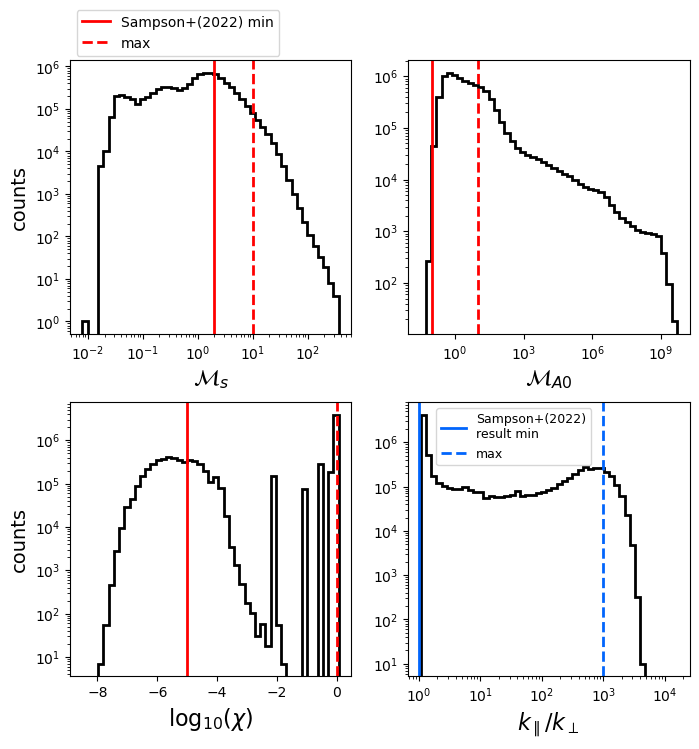

In [6]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].hist(data.gas['M_s'], bins=np.logspace(-2.1,2.56,50), histtype='step', color='k', lw=2);
ax[0,0].set_xlabel('$\mathcal{M}_s$', fontsize=16)
ax[0,0].set_ylabel('counts', fontsize=14)
ax[0,0].axvline(2, color='r', label='Sampson+(2022) min', lw=2)
ax[0,0].axvline(10, color='r', ls='--', label='max', lw=2)
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].legend(loc='center left', bbox_to_anchor=(0, 1.1))

ax[0,1].hist(data.gas['M_A0'], bins=np.logspace(-1.5,9.7,50), histtype='step', color='k', lw=2);
ax[0,1].set_xlabel('$\mathcal{M}_{A0}$', fontsize=16)
ax[0,1].axvline(0.1, color='r', lw=2)
ax[0,1].axvline(10, color='r', ls='--', lw=2)
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')

ax[1,0].hist(np.log10(data.gas['xion']), bins=np.linspace(-8.5, 0.064, 50), histtype='step', color='k', lw=2);
ax[1,0].set_xlabel('log$_{10}(\chi)$', fontsize=16)
ax[1,0].set_ylabel('counts', fontsize=14)
ax[1,0].set_yscale('log')
ax[1,0].axvline(-5, color='r', lw=2)
ax[1,0].axvline(0, color='r', ls='--', lw=2)


ax[1,1].hist(data.gas['kratio'], bins=np.logspace(0.03, 4.2, 50), histtype='step', color='k', lw=2);
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('$k_\parallel/k_\perp$', fontsize=16)
ax[1,1].axvline(1, color='xkcd:bright blue', lw=2, label='Sampson+(2022)\nresult min')
ax[1,1].axvline(1000, color='xkcd:bright blue', ls='--', lw=2, label='max')
ax[1,1].legend(loc=(0.1,0.77), fontsize=9)

plt.subplots_adjust(hspace=0.25)

In [4]:
fit_kratios = fitfunc('k_ratio', data.gas['M_A0'], data.gas['xion'])
fit_kperps = fitfunc('k_perp', data.gas['M_A0'], data.gas['xion'])

In [63]:
kratios = fit_kratios
kperps = fit_kperps
kpars_us = fit_kratios * fit_kperps
data.gas['kratio'] = pynbody.array.SimArray(kratios, units='')
data.gas['kpar_us'] = pynbody.array.SimArray(kpars_us, units='') # unscaled
data.gas['kperp_us'] = pynbody.array.SimArray(kperps, units='') # unscaled

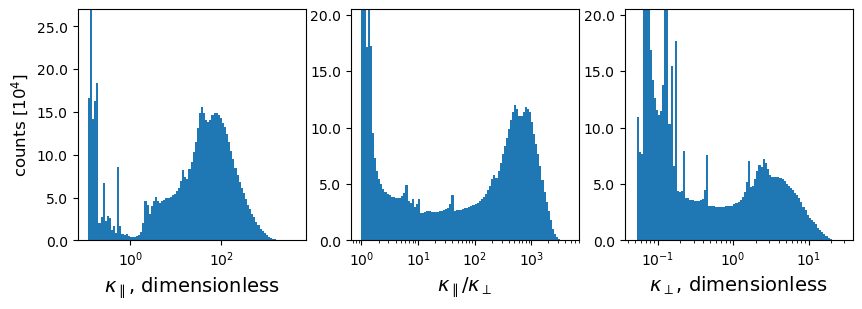

In [71]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].hist(kpars_us, np.logspace(np.log10(kpars_us.min()),np.log10(kpars_us.max()), 100));
ax[0].set_xscale('log')
#plt.yscale('log')
ax[0].set_ylim([0,0.27e6])
ax[0].set_xlabel('$\kappa_\parallel$, dimensionless', fontsize=14)
ax[0].set_ylabel('counts [10$^4$]', fontsize=12)
ax[0].set_yticks(np.arange(0,2.5e5+50000,50000), np.arange(0,2.5e5+50000,50000)/1e4);

ax[1].hist(kratios, np.logspace(0,np.log10(4600), 100));
ax[1].set_xscale('log')
#plt.yscale('log')
ax[1].set_ylim([0,0.205e6])
ax[1].set_xlabel('$\kappa_\parallel/\kappa_\perp$', fontsize=14)
ax[1].set_yticks(np.arange(0,2e5+50000,50000), np.arange(0,2e5+50000,50000)/1e4);

ax[2].hist(kperps, np.logspace(np.log10(0.05),np.log10(28), 100));
ax[2].set_xscale('log')
ax[2].set_ylim([0,0.205e6])
ax[2].set_xlabel('$\kappa_\perp$, dimensionless', fontsize=14)
ax[2].set_yticks(np.arange(0,2e5+50000,50000), np.arange(0,2e5+50000,50000)/1e4);

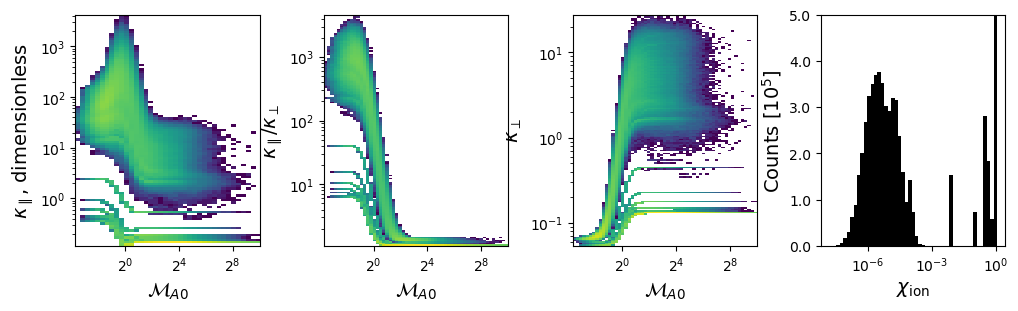

In [73]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
h, xbins = np.histogram(data.gas['M_A0'], bins=np.logspace(np.log2(data.gas['M_A0'].min()),
                                                          np.log2(data.gas['M_A0'].max()), 100, base=2));
h, ybins = np.histogram(kpars_us, bins=np.logspace(np.log10(kpars_us.min()),
                                                          np.log10(kpars_us.max()), 100));
ax[0].hist2d(data.gas['M_A0'], kpars_us, bins=(xbins, ybins), norm=LogNorm());
ax[0].set_xscale('log', base=2)
ax[0].set_yscale('log', base=10)
ax[0].set_ylabel('$\kappa_\parallel$, dimensionless', fontsize=14)
ax[0].set_xlabel('$\mathcal{M}_{A0}$', fontsize=14)
ax[0].set_xlim(right=2**10)

h, xbins = np.histogram(data.gas['M_A0'], bins=np.logspace(np.log2(data.gas['M_A0'].min()),
                                                          np.log2(data.gas['M_A0'].max()), 150, base=2));
h, ybins = np.histogram(kratios, bins=np.logspace(np.log10(kratios.min()),
                                                          np.log10(kratios.max()), 150));
ax[1].hist2d(data.gas['M_A0'], kratios, bins=(xbins, ybins), norm=LogNorm());
ax[1].set_xscale('log', base=2)
ax[1].set_yscale('log', base=10)
ax[1].set_ylabel('$\kappa_\parallel/\kappa_\perp$', fontsize=14)
ax[1].set_xlabel('$\mathcal{M}_{A0}$', fontsize=14)
ax[1].set_xlim(right=2**10)

h, xbins = np.histogram(data.gas['M_A0'], bins=np.logspace(np.log2(data.gas['M_A0'].min()),
                                                          np.log2(data.gas['M_A0'].max()), 150, base=2));
h, ybins = np.histogram(kperps, bins=np.logspace(np.log10(kperps.min()),
                                                          np.log10(kperps.max()), 150));
ax[2].hist2d(data.gas['M_A0'], kperps, bins=(xbins, ybins), norm=LogNorm());
ax[2].set_xscale('log', base=2)
ax[2].set_yscale('log', base=10)
ax[2].set_ylabel('$\kappa_\perp$', fontsize=14)
ax[2].set_xlabel('$\mathcal{M}_{A0}$', fontsize=14)
ax[2].set_xlim(right=2**10)

ax[3].hist(data.gas['xion'], np.logspace(np.log10(data.gas['xion'].min()), 
                                         np.log10(data.gas['xion'].max()), 50), color='k');
ax[3].set_xscale('log')
ax[3].set_ylim([0,0.5e6])
ax[3].set_xlabel(r'$\chi_{\rm{ion}}$', fontsize=14)
ax[3].set_yticks(np.arange(0,6e5,1e5), np.arange(0,6e5,1e5)/1e5);
ax[3].set_ylabel('Counts [10$^5$]', fontsize=14)

plt.subplots_adjust(wspace=0.35)

Text(0.85, 1.04, 'Sampson+(2022) Fit')

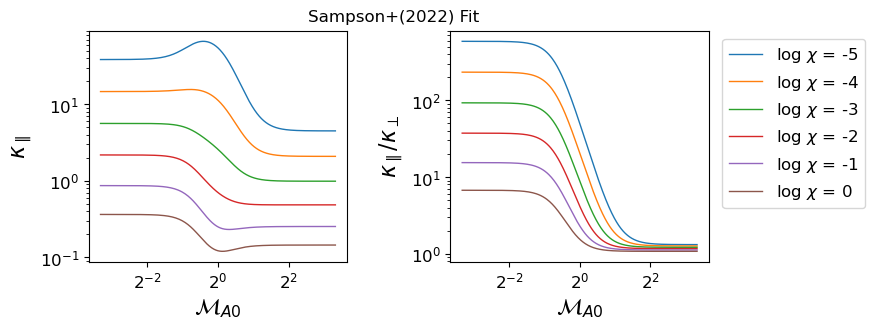

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
Mvals = np.linspace(0.1, 10, 1000)
chivals = 10. ** np.arange(-5,1,1)

for chi in chivals:
    kratiosM = []
    kperpsM = []
    kparsM = []
    for M_A0 in Mvals:
        kratiosM.append(fitfunc('k_ratio', M_A0, chi))
        kperpsM.append(fitfunc('k_perp', M_A0, chi))
        kparsM.append(fitfunc('k_ratio', M_A0, chi)*fitfunc('k_perp', M_A0, chi))
    ax[0].plot(Mvals, kparsM, lw=1, label='log $\chi$ = {}'.format(int(np.log10(chi))))

ax[0].set_yscale('log')
ax[0].set_xscale('log', base=2)
ax[0].set_xlabel('$\mathcal{M}_{A0}$', fontsize=16)
ax[0].set_ylabel('$\kappa_\parallel/\kappa_\perp$', fontsize=16)
ax[0].set_ylabel('$\kappa_\parallel$', fontsize=16)
ax[0].tick_params(labelsize=12)

for chi in chivals:
    kratiosM = []
    for M_A0 in Mvals:
        kratiosM.append(fitfunc('k_ratio', M_A0, chi))
    ax[1].plot(Mvals, kratiosM, lw=1, label='log $\chi$ = {}'.format(int(np.log10(chi))))

ax[1].set_yscale('log')
ax[1].set_xscale('log', base=2)
ax[1].set_xlabel('$\mathcal{M}_{A0}$', fontsize=16)
ax[1].set_ylabel('$\kappa_\parallel/\kappa_\perp$', fontsize=16)
ax[1].tick_params(labelsize=12)
ax[1].legend(bbox_to_anchor=(1.02, 1), fontsize=12)

plt.subplots_adjust(wspace=0.4)
ax[0].text(0.85,1.04, 'Sampson+(2022) Fit', fontsize=12, transform=ax[0].transAxes)

### Okay, things are looking as expected. The trends follow similarly to the fit functions presented in Sampson+(2022), especially for the majority of cells having low $(\chi<10^{-4})$ ionization fraction.

### Now let's multiply in the units that Matt uses, $\mathcal{l}_0^{\alpha-1}\sigma_{1D}$, where in our case we use $\alpha=2$ for both the perpendicular and parallel directions.

In [74]:
alphapar = 2
alphaperp = 2
l0 = data.gas['smooth'].in_units('cm').min() / 2

kratios = fit_kratios
kpars = fit_kratios * fit_kperps  * l0**(alphapar-1) * data.gas['sigma1d'].in_units('cm s**-1')
kperps = fit_kperps * l0**(alphapar-1) * data.gas['sigma1d'].in_units('cm s**-1')
data.gas['kpar'] = pynbody.array.SimArray(kpars, units='cm**2 s**-1')
data.gas['kperp'] = pynbody.array.SimArray(kperps, units='cm**2 s**-1')

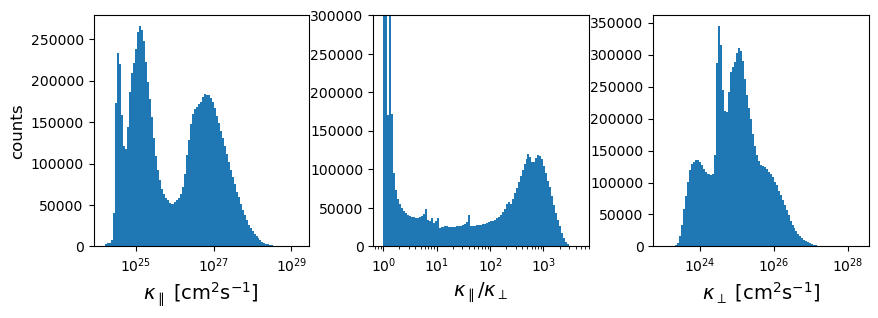

In [75]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].hist(kpars, np.logspace(np.log10(kpars.min()),np.log10(kpars.max()), 100));
ax[0].set_xscale('log')
ax[0].set_xlabel('$\kappa_\parallel$ [cm$^2$s$^{-1}$]', fontsize=14)
ax[0].set_ylabel('counts', fontsize=12)

ax[1].hist(kratios, np.logspace(0,np.log10(4600), 100));
ax[1].set_xscale('log')
ax[1].set_ylim([0,0.3e6])
ax[1].set_xlabel('$\kappa_\parallel/\kappa_\perp$', fontsize=14)

ax[2].hist(kperps, np.logspace(23,np.log10(2e28), 100));
ax[2].set_xscale('log')
ax[2].set_xlabel('$\kappa_\perp$ [cm$^2$s$^{-1}$]', fontsize=14)

plt.subplots_adjust(wspace=0.3)

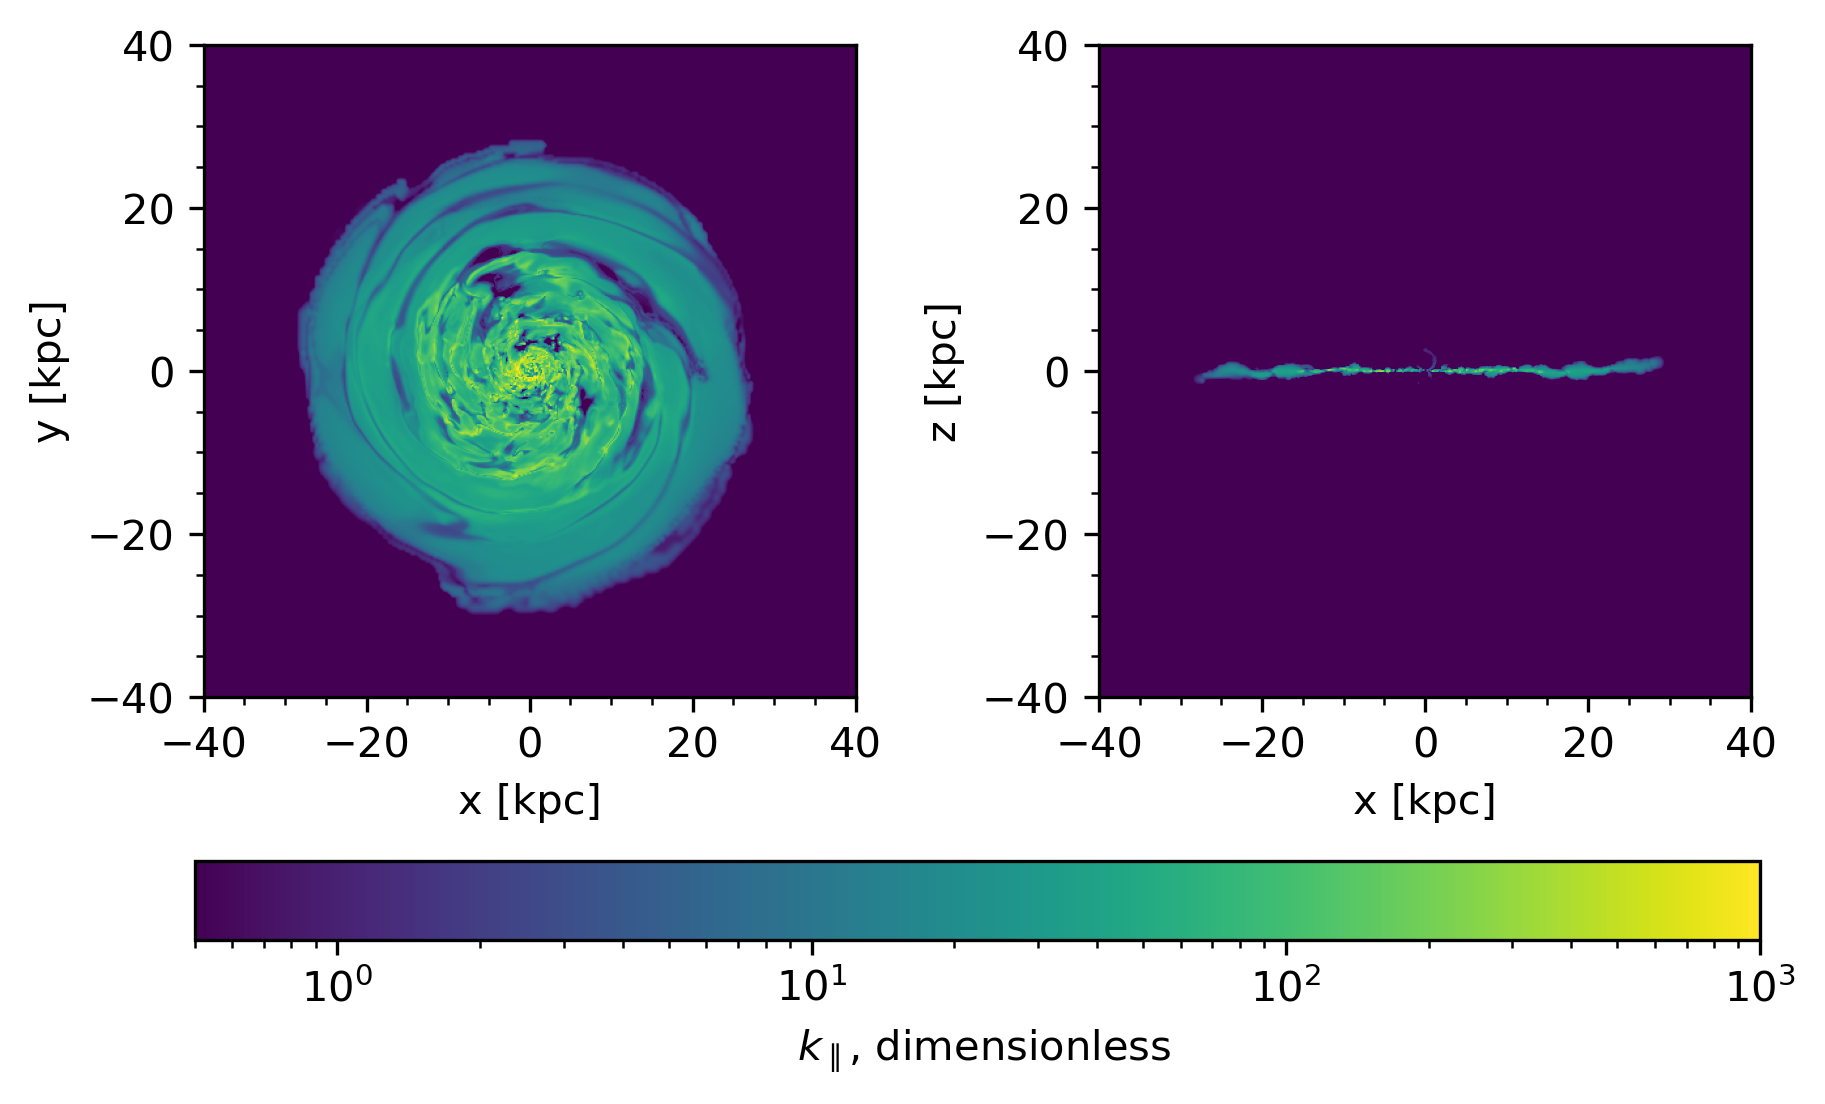

In [91]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='kpar_us', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.5, vmax=1e3, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='kpar_us', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.5, vmax=1e3, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $k_\parallel$, dimensionless")
plt.show()

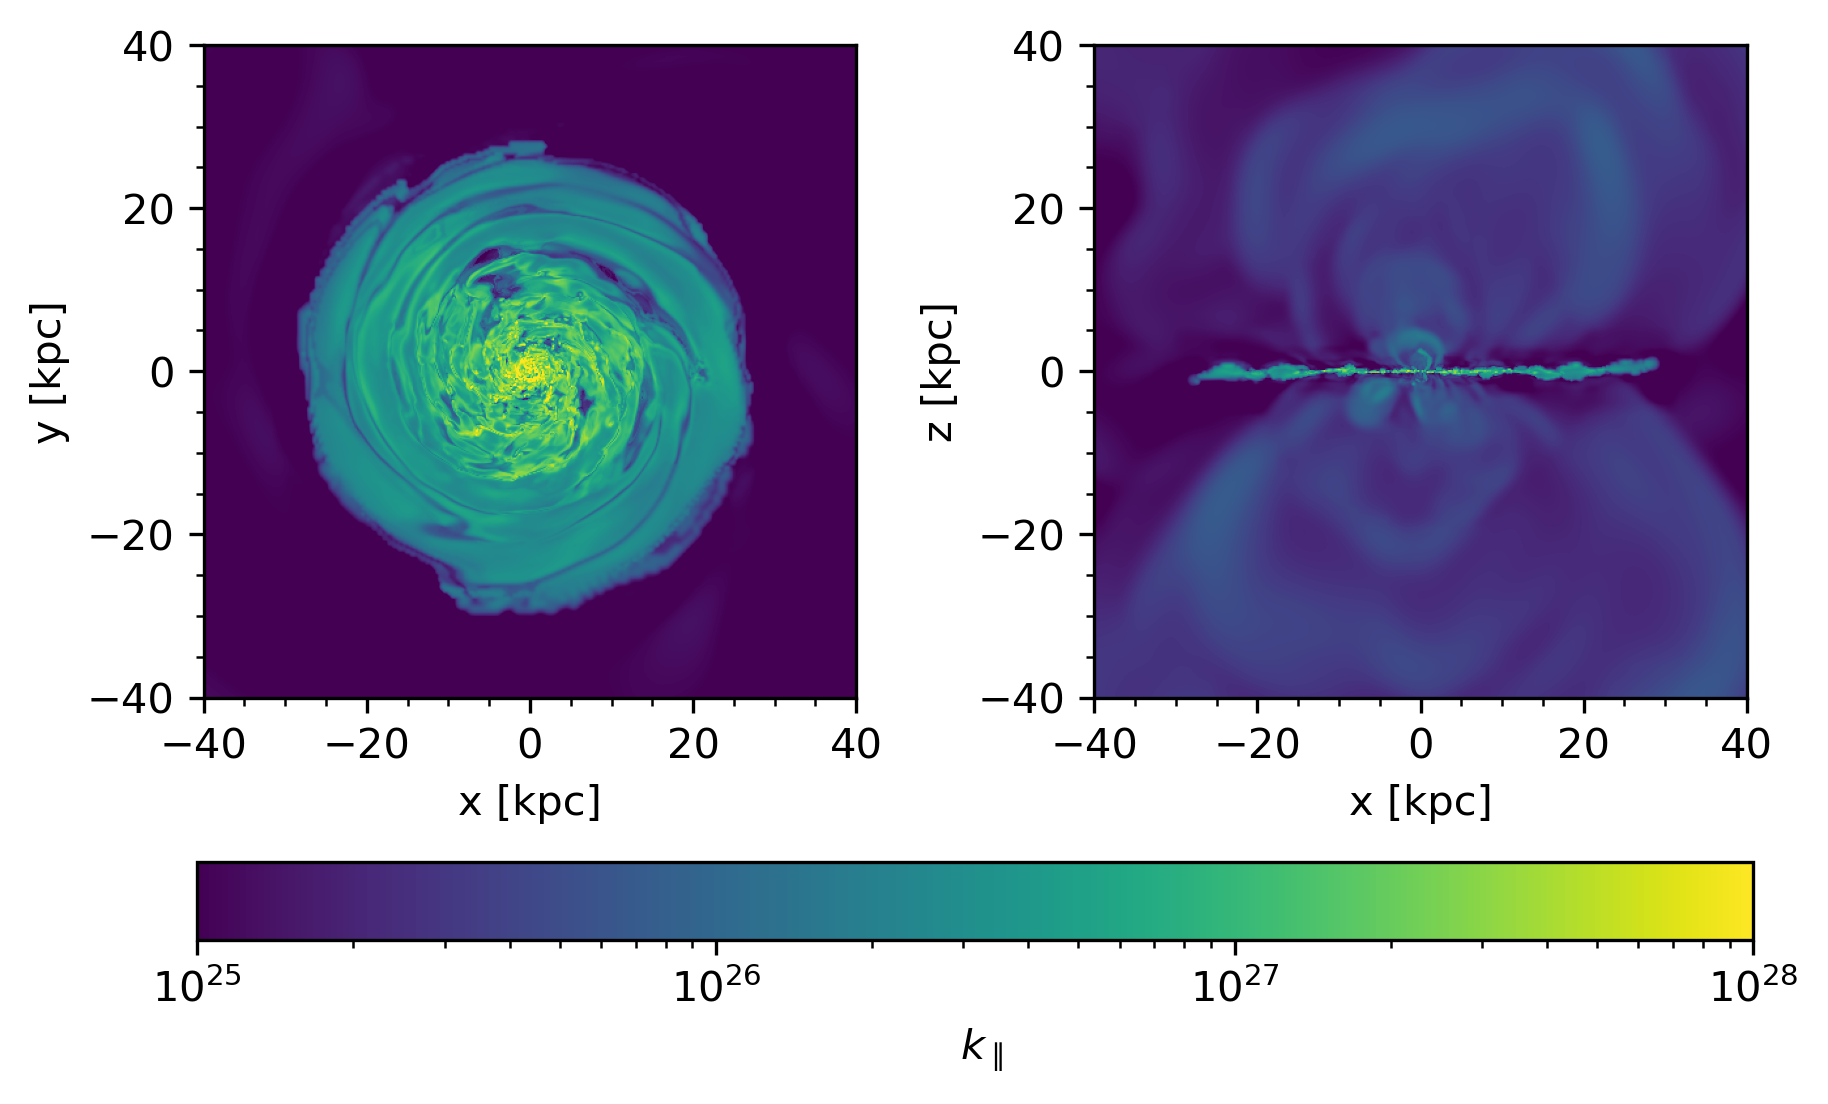

In [77]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='kpar', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e25, vmax=1e28, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='kpar', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e25, vmax=1e28, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $k_\parallel$")
plt.show()

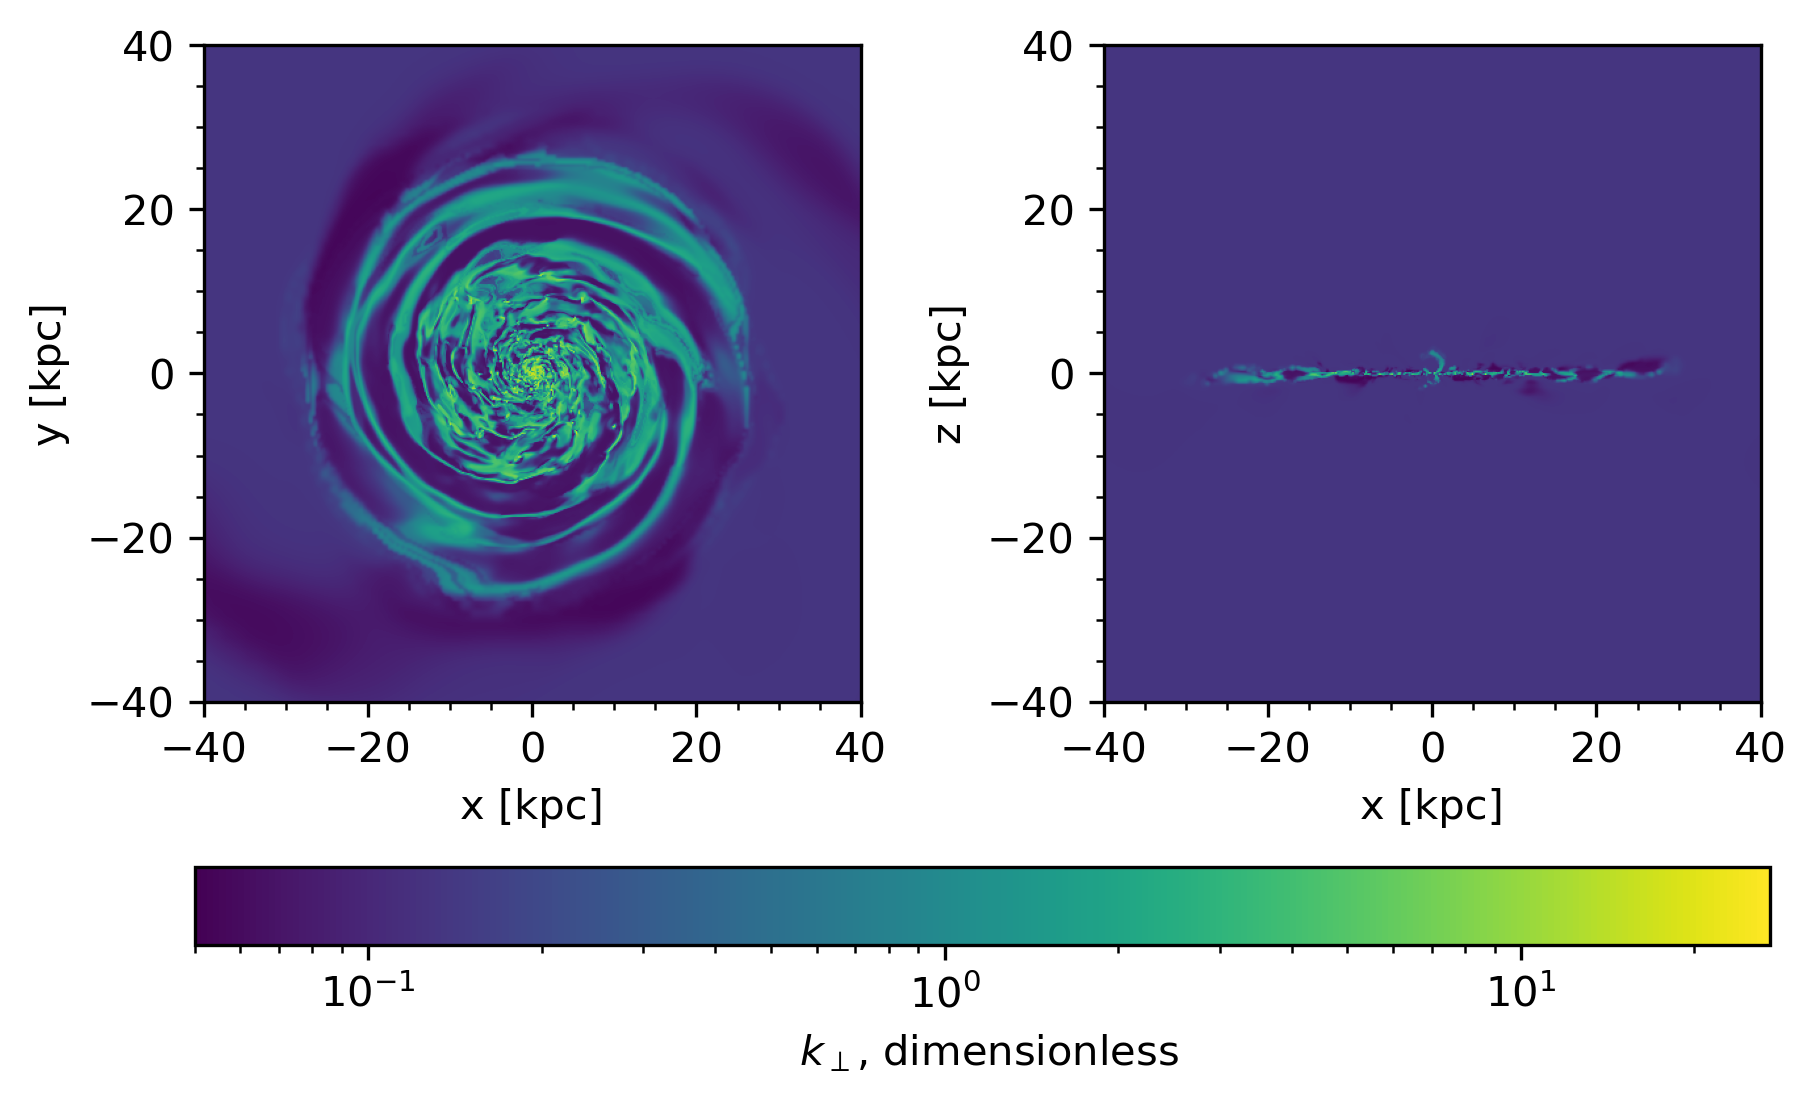

In [81]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='kperp_us', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.05, vmax=27, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='kperp_us', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.05, vmax=27, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $k_\perp$, dimensionless")
plt.show()

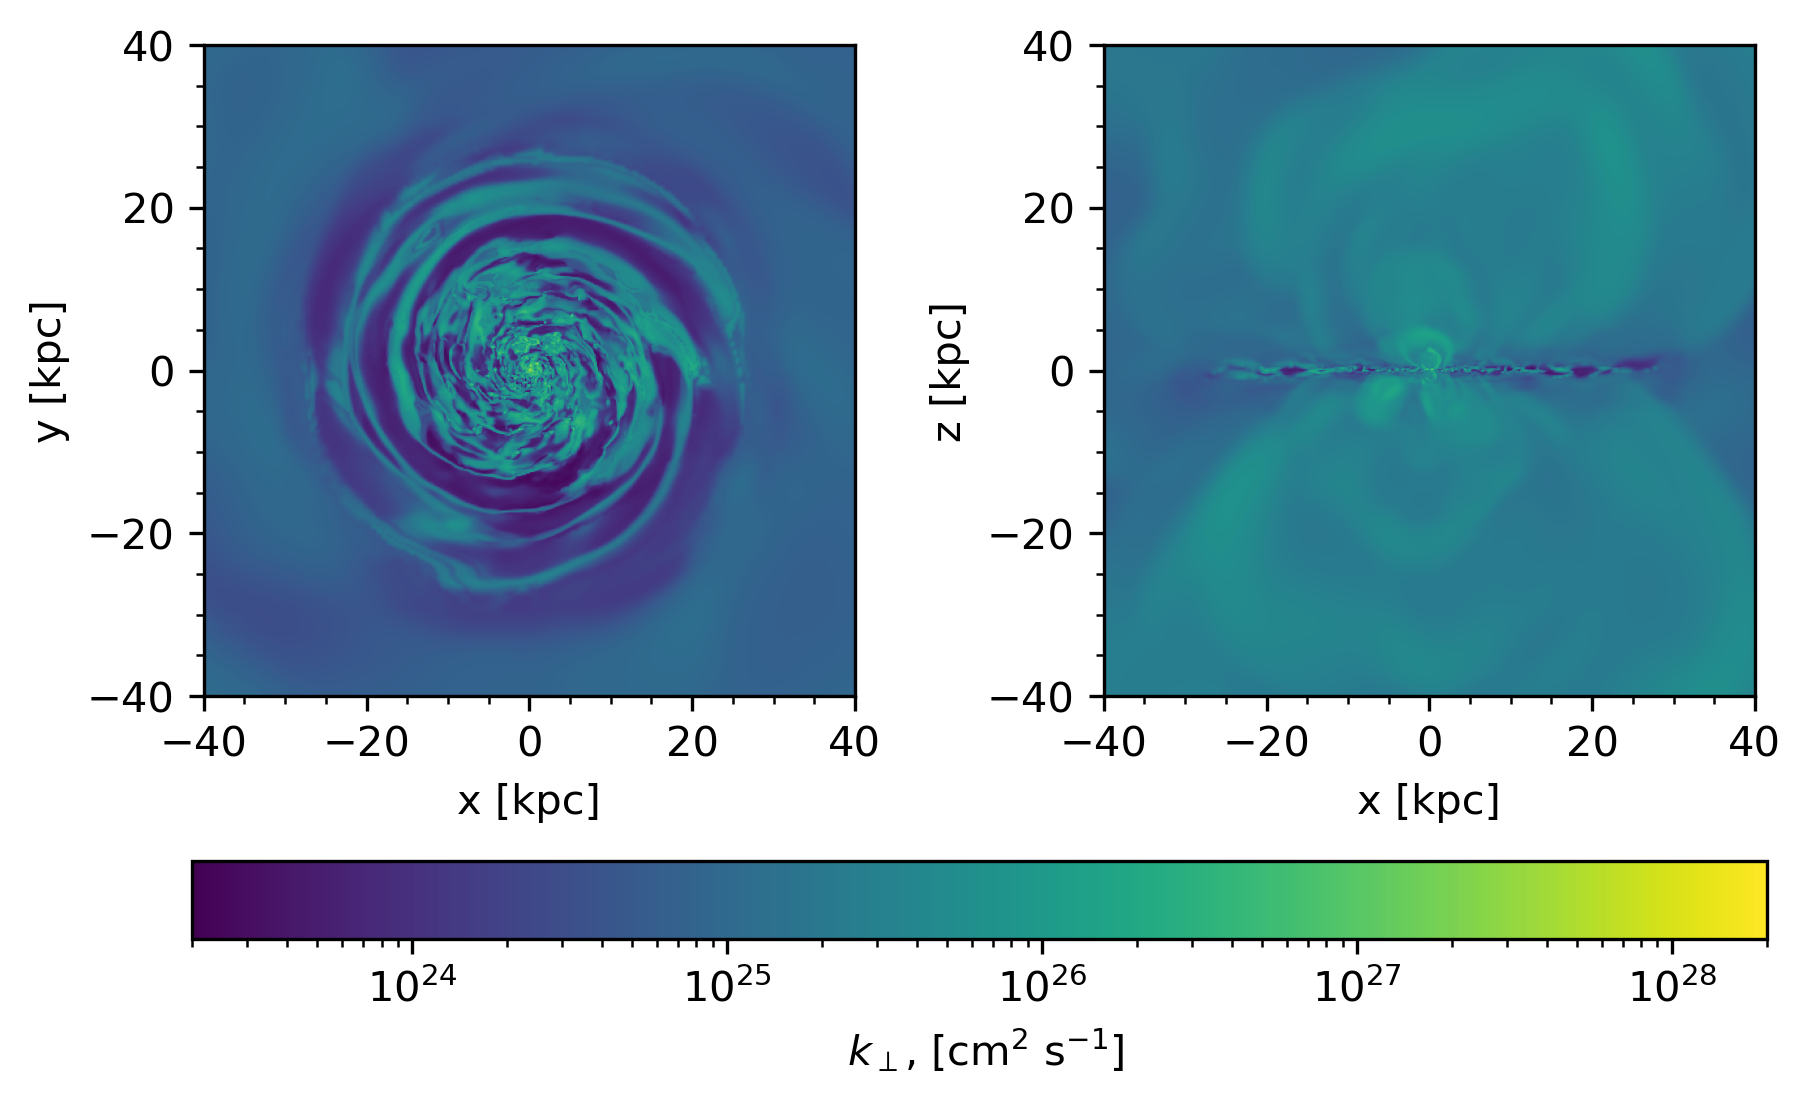

In [86]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='kperp', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=2e23, vmax=2e28, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='kperp', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=2e23, vmax=2e28, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $k_\perp$, [cm$^2$ s$^{-1}$]")
plt.show()

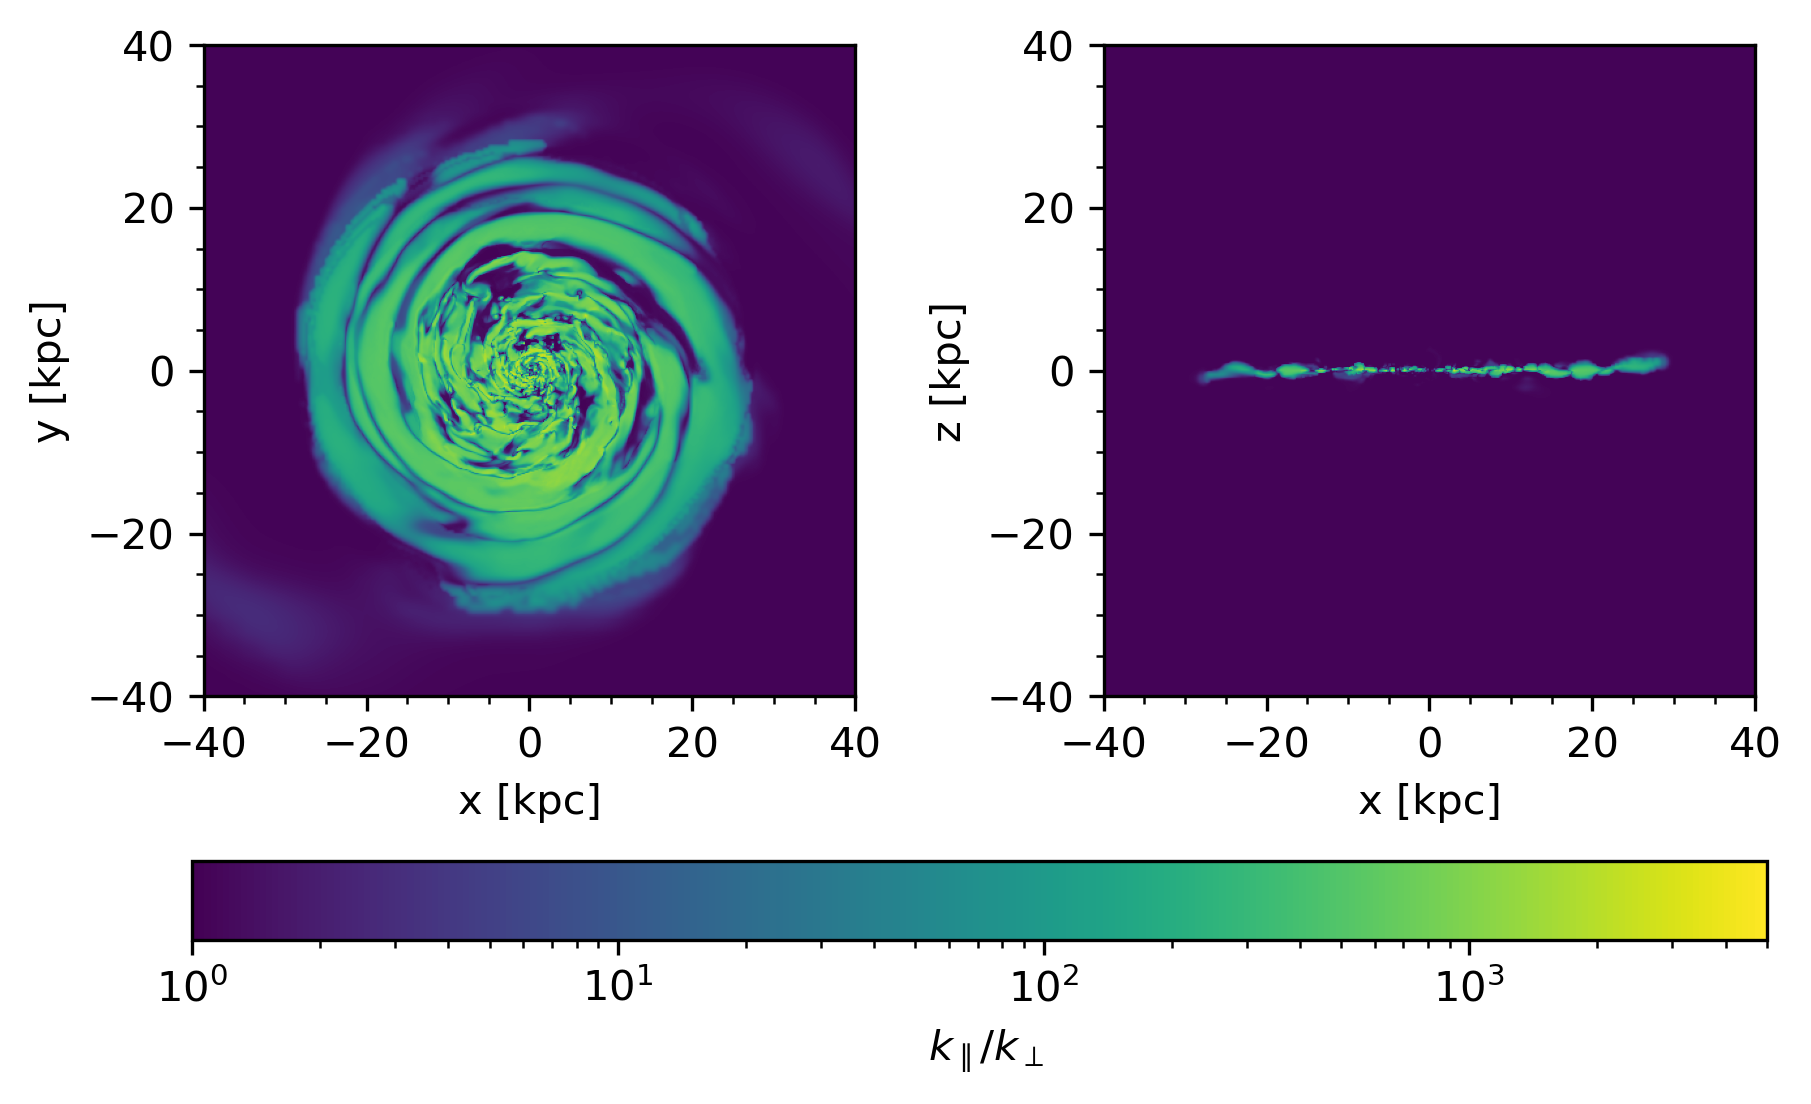

In [25]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w = 80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='kratio', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1, vmax=5e3, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='kratio', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1, vmax=5e3, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $k_\parallel/k_\perp$")
plt.show()

### Before, $\kappa_\parallel$ increased again far away from the galaxy in the unit-corrected version. Now, we keep the injection scale $l_0$ equal to the minimum cell size, so that the diffusion coefficient does not depend on the simulation resolution.

### If we don't do this, the injection scale looks like this:

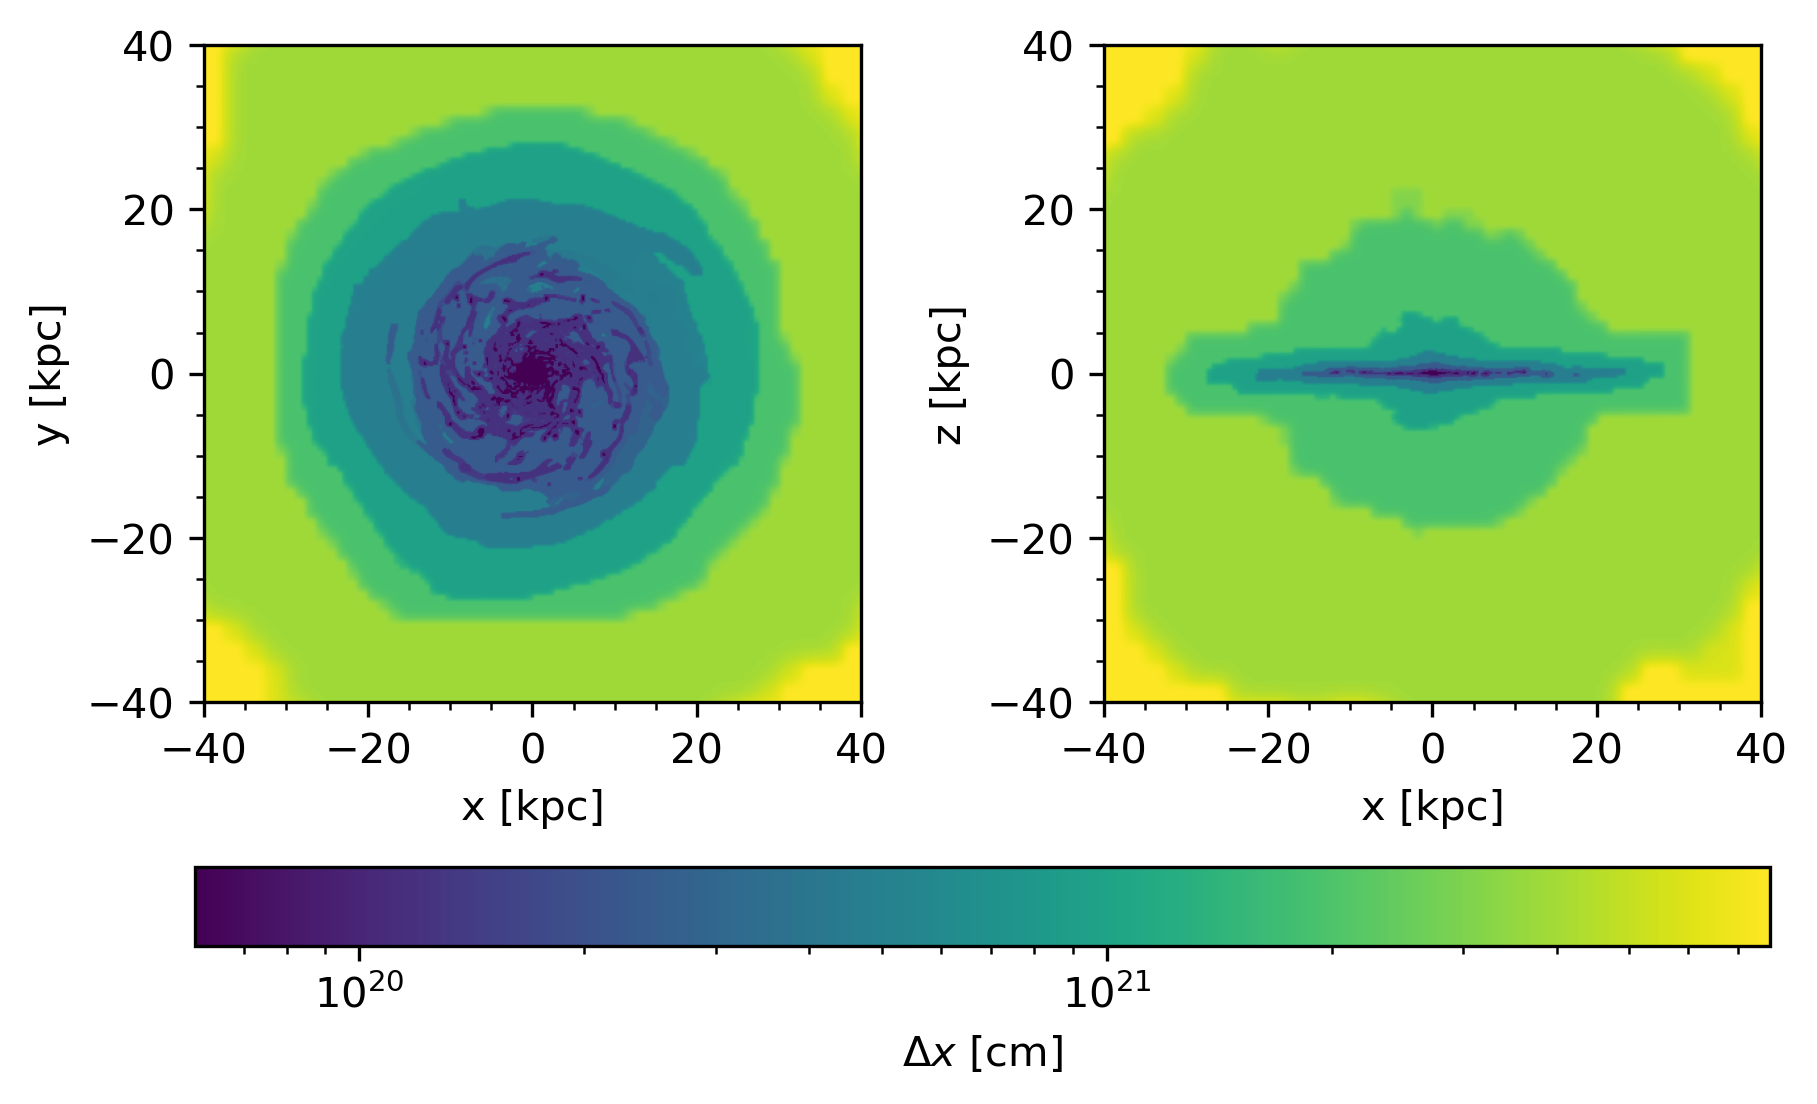

In [88]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='smooth', units='cm', width="%f kpc"%(w), ret_im=True,
                        log=True, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='smooth', units='cm', width="%f kpc"%(w), ret_im=True,
                        log=True, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$\Delta x$ [cm]")
plt.show()

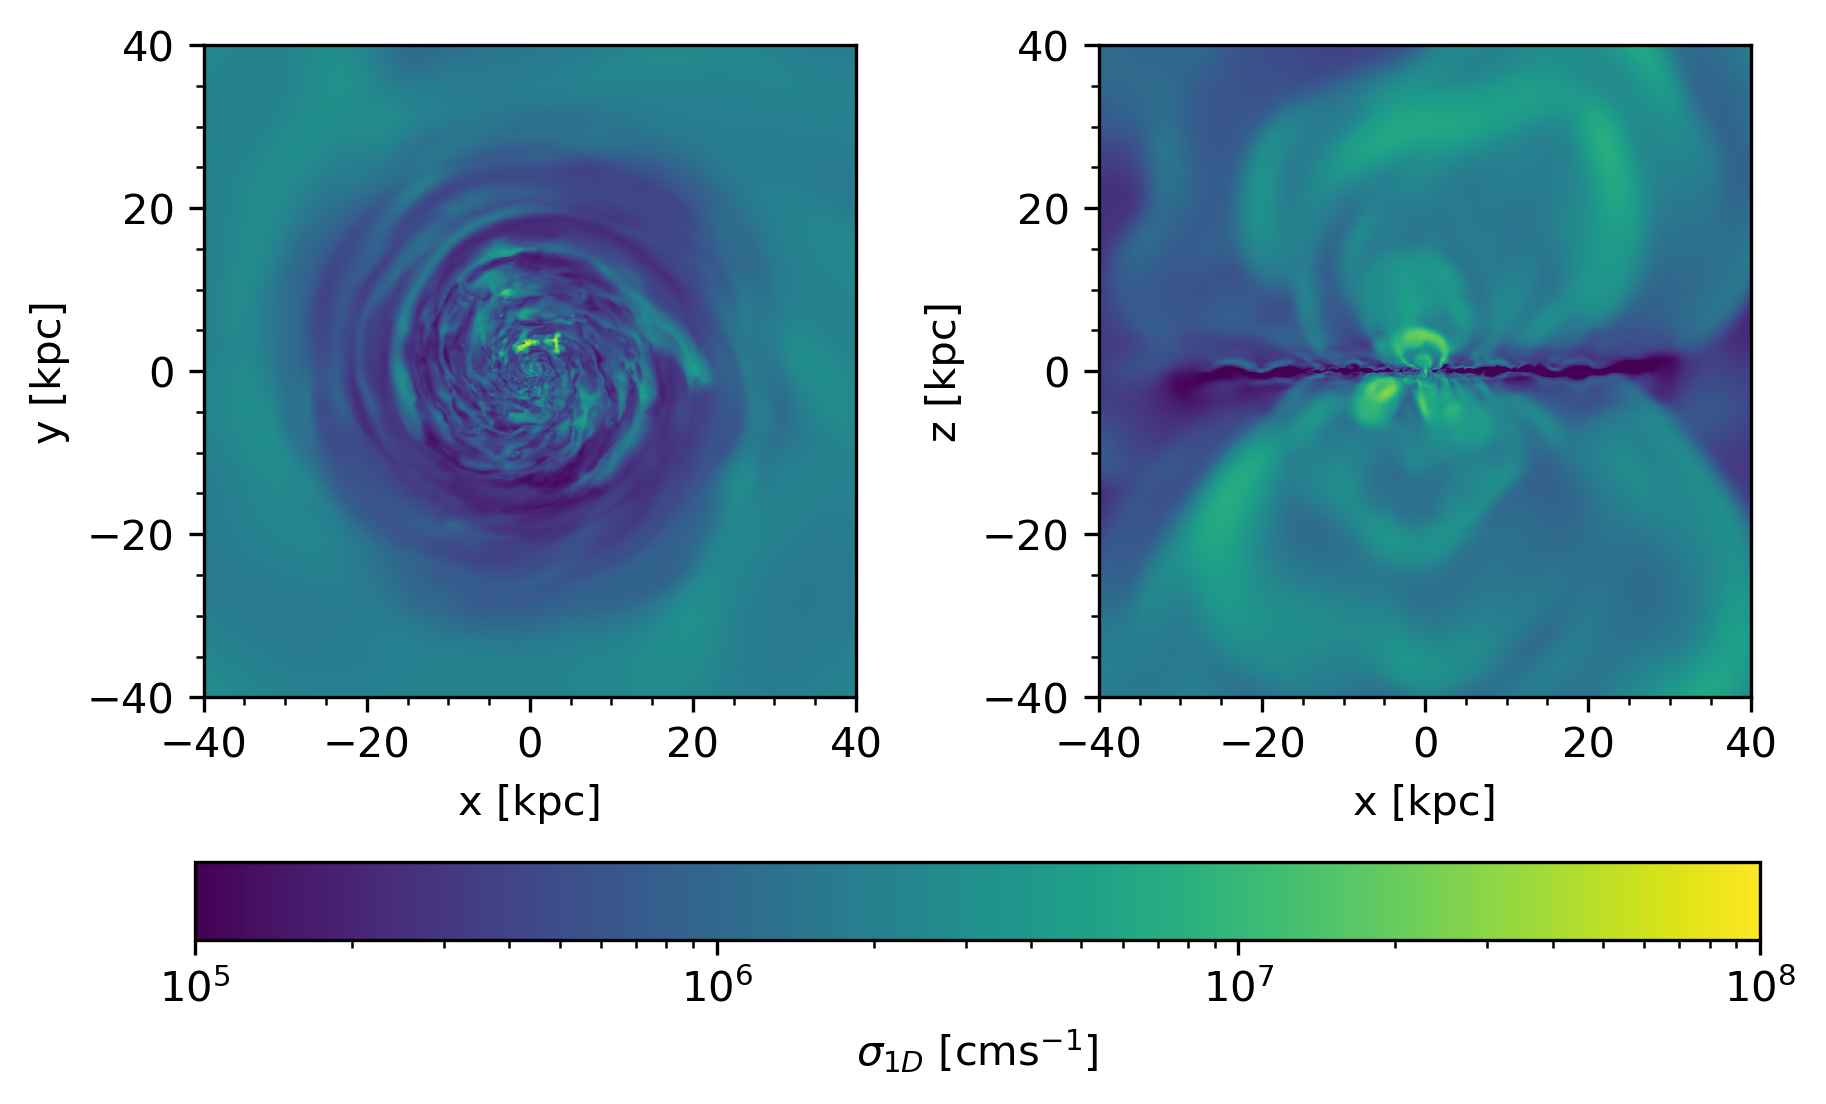

In [11]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=80
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='sigma1d', units='cm s**-1', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e5, vmax=1e8, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='sigma1d', units='cm s**-1', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e6, vmax=1e8, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$\sigma_{1D}$ [cms$^{-1}$]")
plt.show()

### And the scale factor was:

In [13]:
data.gas['scale'] = data.gas['smooth'].in_units('cm') / 2 * data.gas['sigma1d'].in_units('cm s**-1')

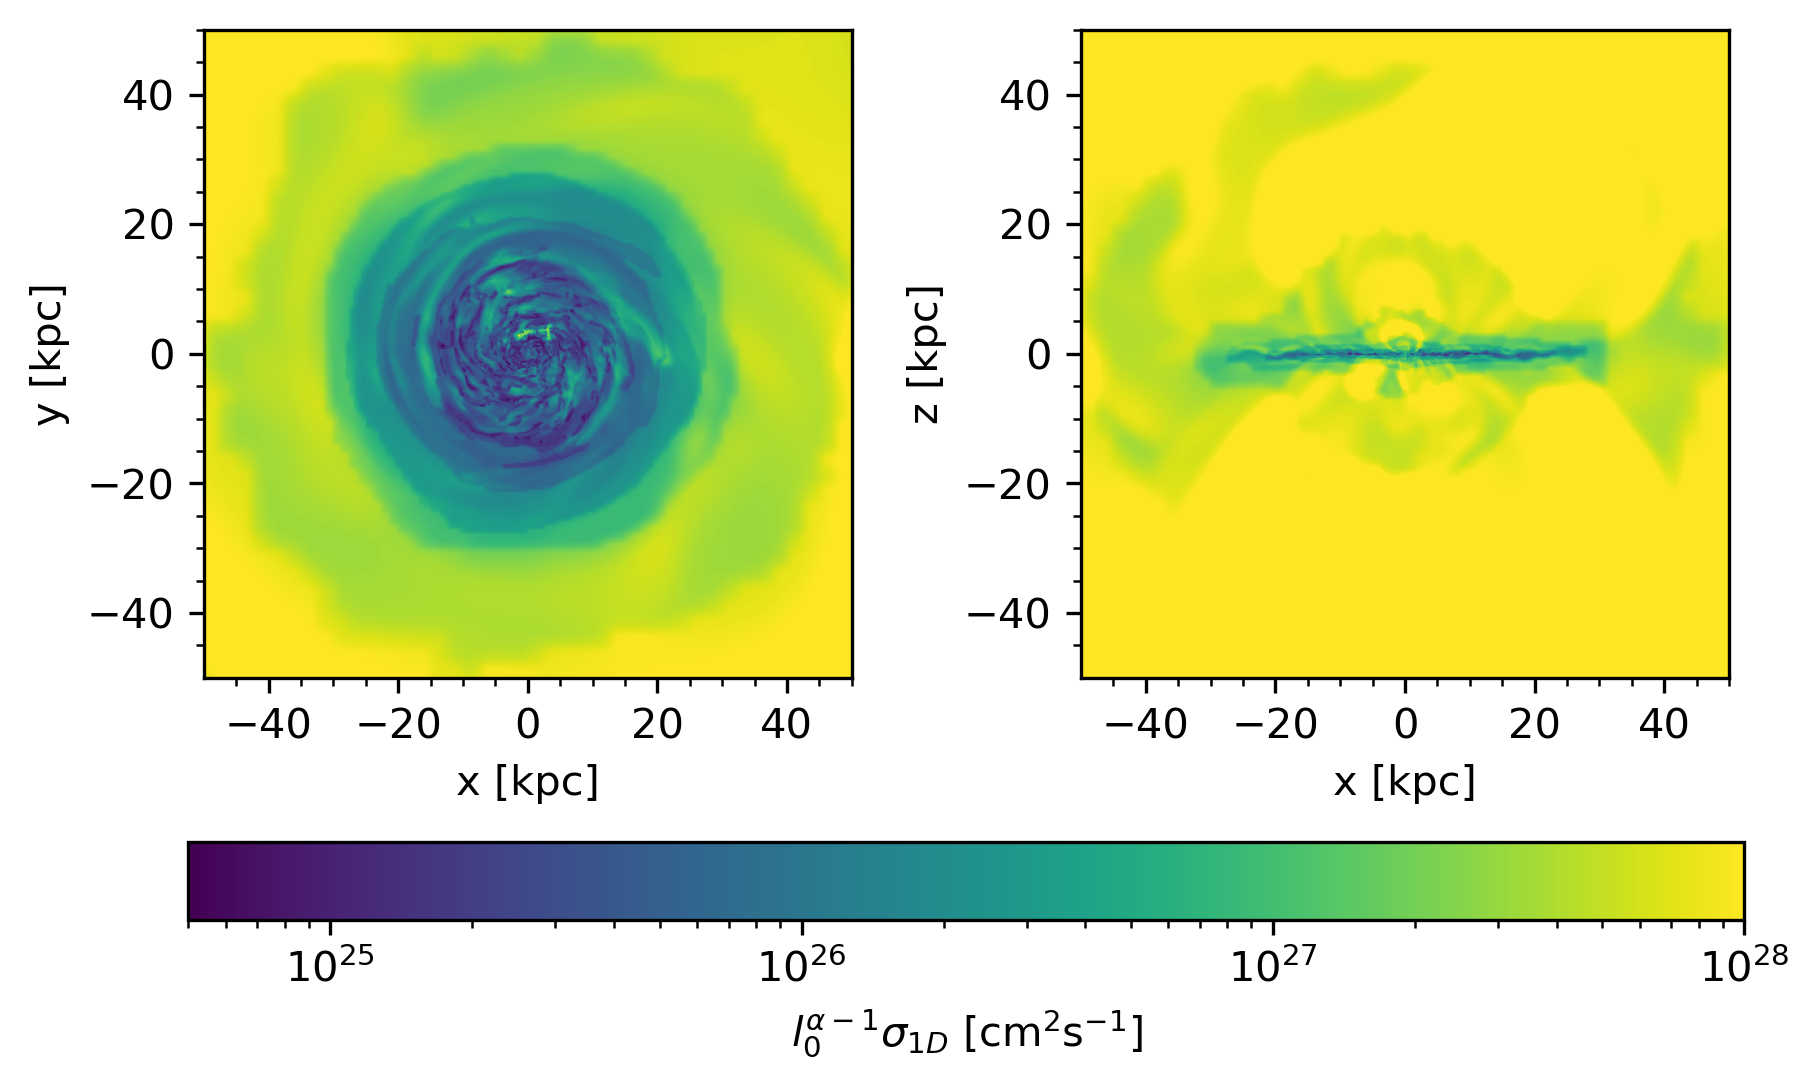

In [14]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=100
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='scale', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=5e24, vmax=1e28, resolution=500, cmap="viridis",    
                        subplot=axs[0], show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='scale', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=5e24, vmax=1e28, resolution=500, cmap="viridis", 
                        subplot=axs[1], show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$l_0^{\alpha-1}\sigma_{1D}$ [cm$^2$s$^{-1}$]")
plt.show()

### Now, the scale factor looks like this (notice the smoothness):

In [92]:
data.gas['scale'] = data.gas['smooth'].in_units('cm').min() / 2 * data.gas['sigma1d'].in_units('cm s**-1')

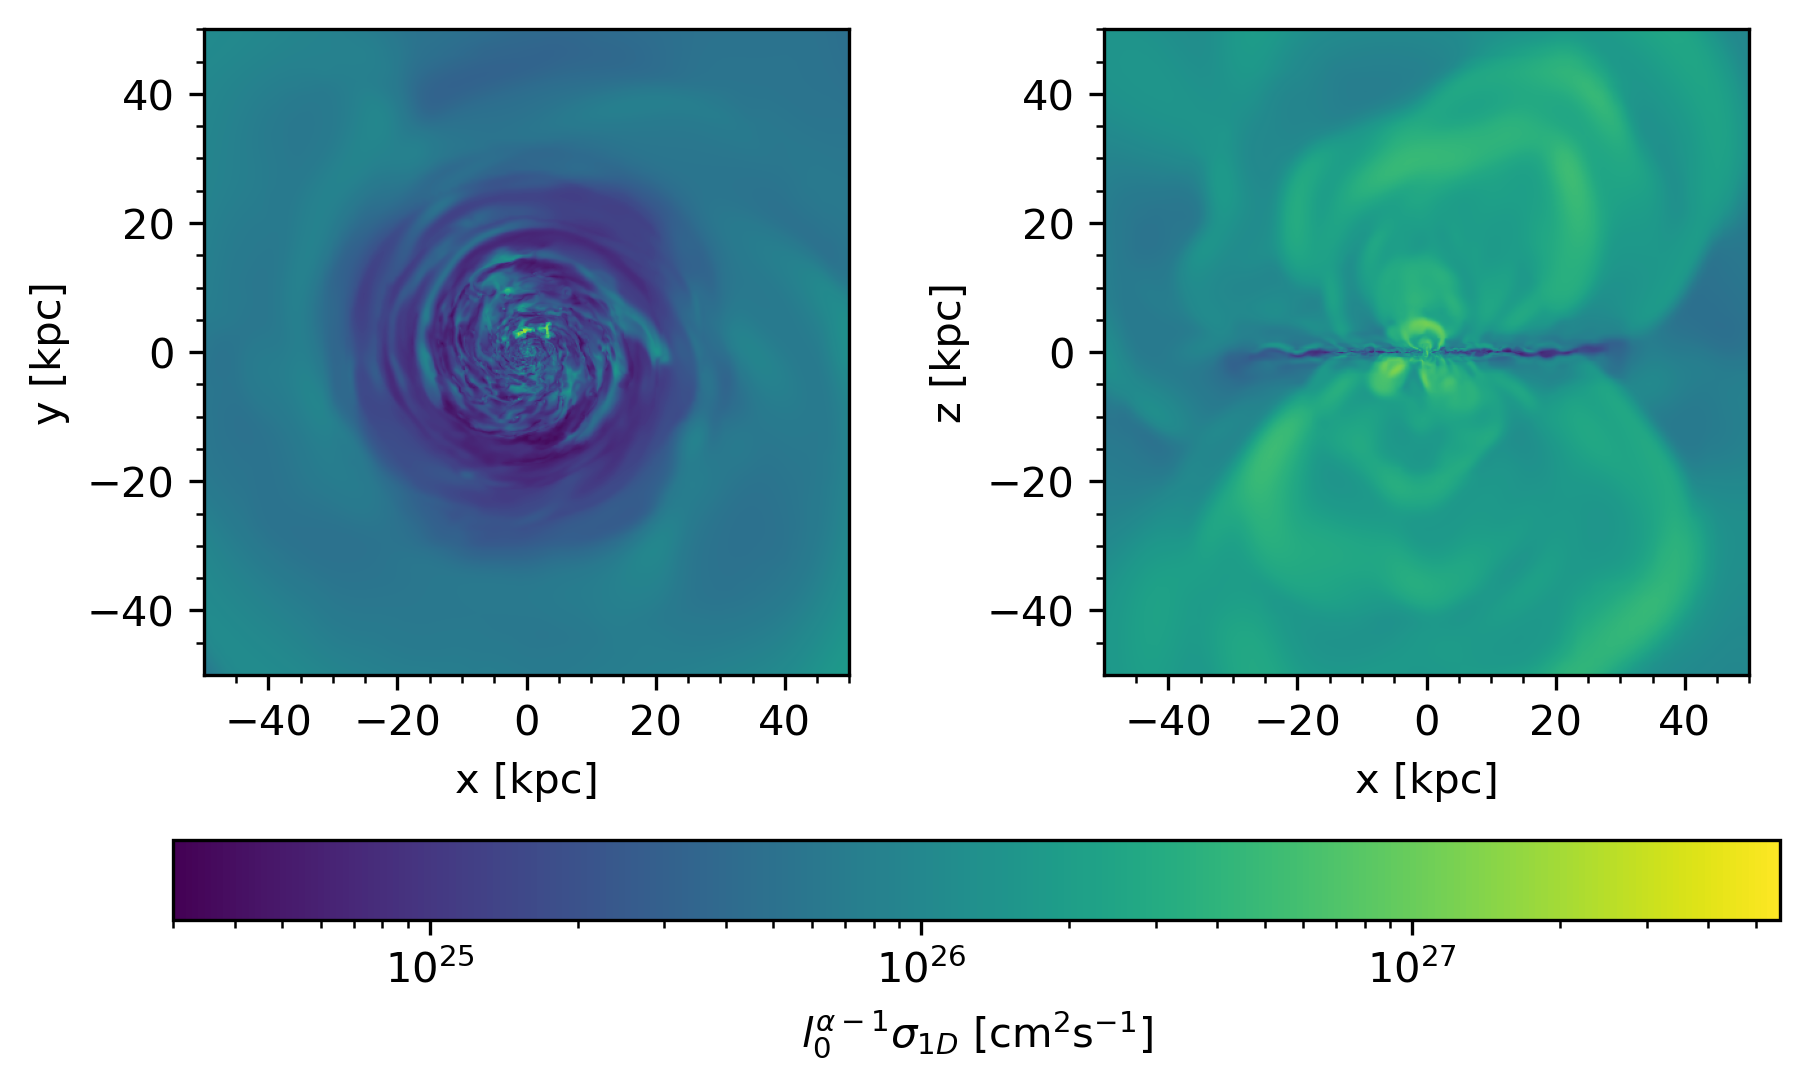

In [94]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=100
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='scale', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=3e24, vmax=5.6e27, resolution=500, cmap="viridis",    
                        subplot=axs[0], show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='scale', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=3e24, vmax=5.6e27, resolution=500, cmap="viridis", 
                        subplot=axs[1], show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$l_0^{\alpha-1}\sigma_{1D}$ [cm$^2$s$^{-1}$]")
plt.show()

## Yan & Lazarian (2008) approximations:

In [95]:
Dpar, Dperp = YL_approx(data)
Dratio = Dpar/Dperp
Dratio = np.round(Dratio, 10)

6.0267140259414065e+19


In [96]:
data.gas['Dratio'] = pynbody.array.SimArray(Dratio, units='')
data.gas['Dpar'] = pynbody.array.SimArray(Dpar, units='cm**2 s**-1')
data.gas['Dperp'] = pynbody.array.SimArray(Dperp, units='cm**2 s**-1')

Text(0.5, 0, '$D_\\perp$ [cm$^2$s$^-1$]')

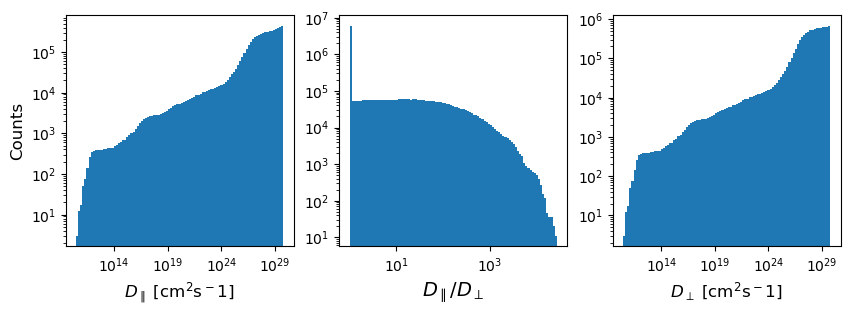

In [98]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].hist(Dpar, np.logspace(np.log10(Dpar.min()),np.log10(Dpar.max()), 100));
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$D_\parallel$ [cm$^2$s$^-1$]', fontsize=12)
ax[0].set_ylabel('Counts', fontsize=12)

ax[1].hist(Dratio, np.logspace(np.log10(Dratio.min()),np.log10(Dratio.max()), 100));
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$D_\parallel/D_\perp$', fontsize=14)

ax[2].hist(Dperp, np.logspace(np.log10(Dperp.min()),np.log10(Dperp.max()), 100));
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('$D_\perp$ [cm$^2$s$^-1$]', fontsize=12)

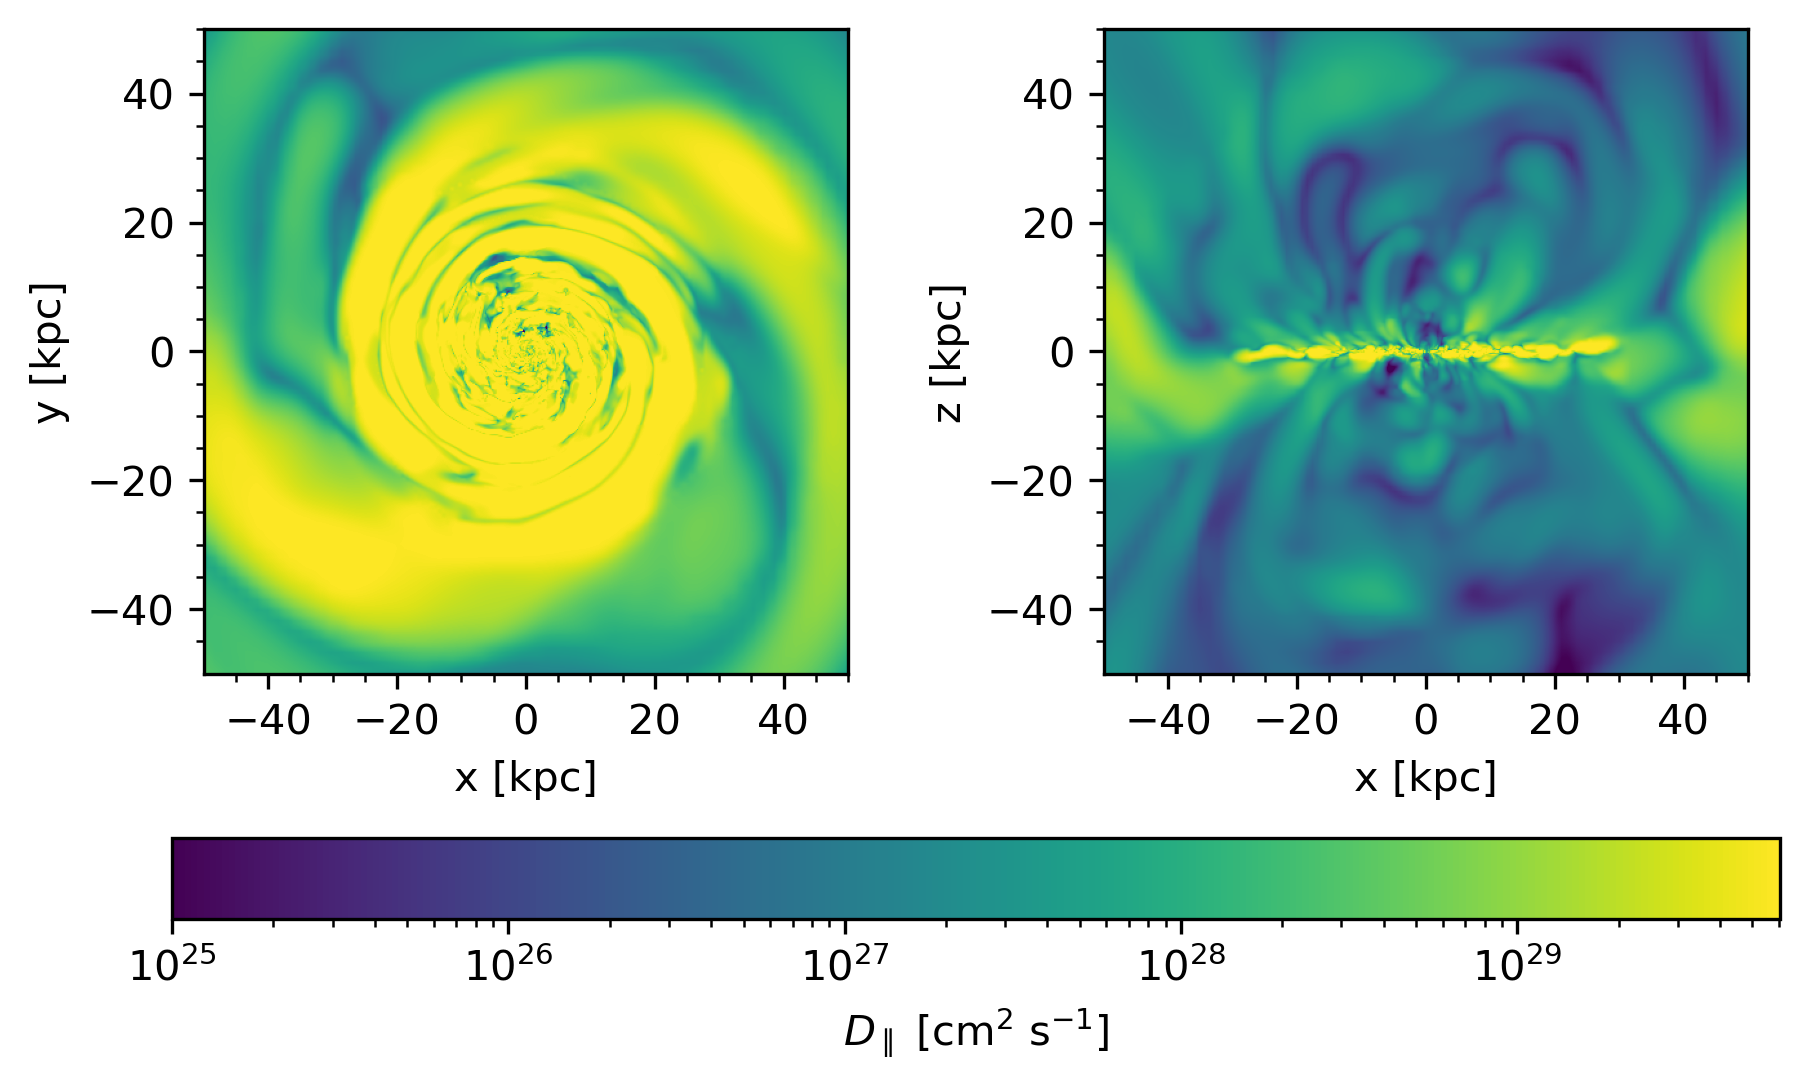

In [107]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=100
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='Dpar', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e25, vmax=Dpar.max(), resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='Dpar', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e25, vmax=Dpar.max(), resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$D_\parallel$ [cm$^2$ s$^{-1}$]")
plt.show()

### Whacky. Recall that the different regimes for parallel diffusion coefficient in our approximation of Y&L(2008) is:

\begin{align*}
    D_\parallel &= \frac{Lc}{3}, & \mathcal{M}_{A0}<1 \\
    D_\parallel &= \frac{Lc}{3\mathcal{M}_{A0}^2}, & \mathcal{M}_{A0}>1
\end{align*}

Where we take L to be the minimum cell size in the RAMSES snapshot created by AMR. Note the variation taken from Burgers turbulence to make supersonic $D_\parallel \propto \mathcal{M}_{A0}^{-2}$ rather than $\mathcal{M}_{A0}^{-3}$.

Let's check out the spatial distribution of Alfven Mach number $\mathcal{M}_{A0}$:

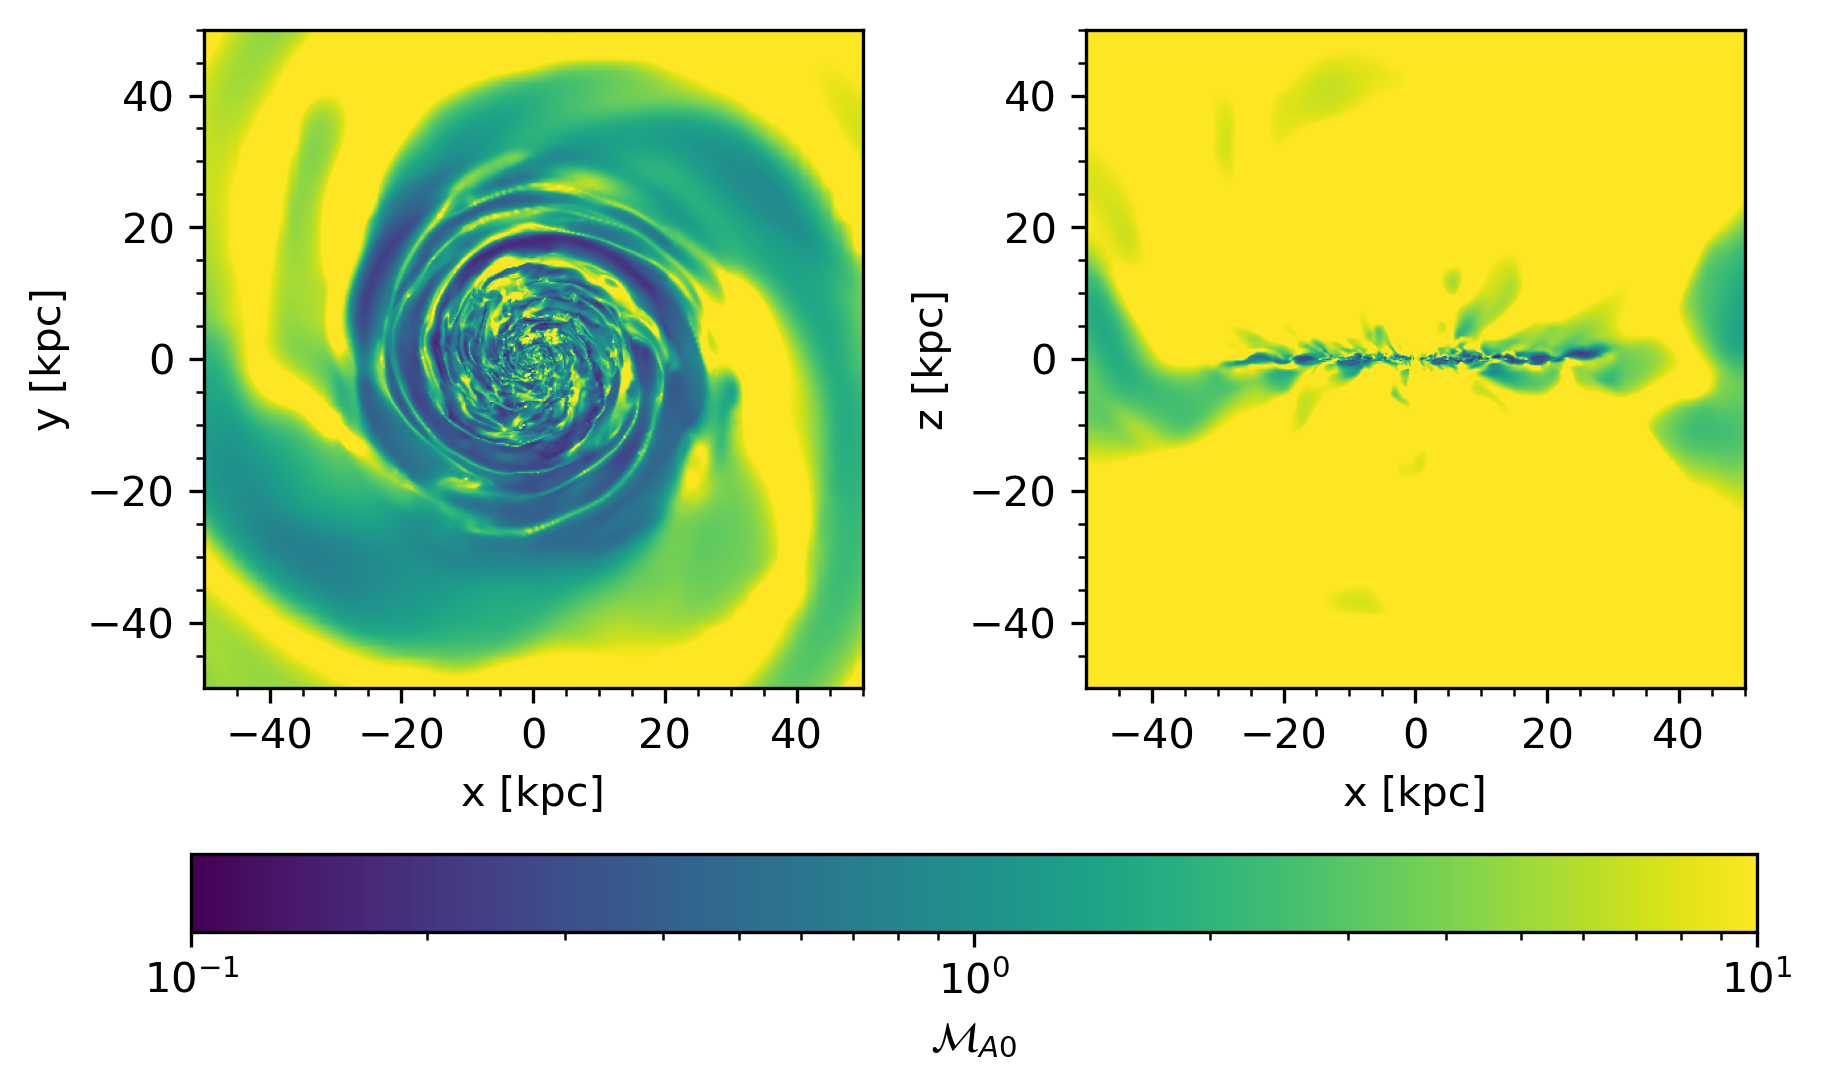

In [179]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=100
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.1, vmax=10, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='M_A0', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.1, vmax=10, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$\mathcal{M}_{A0}$")
plt.show()

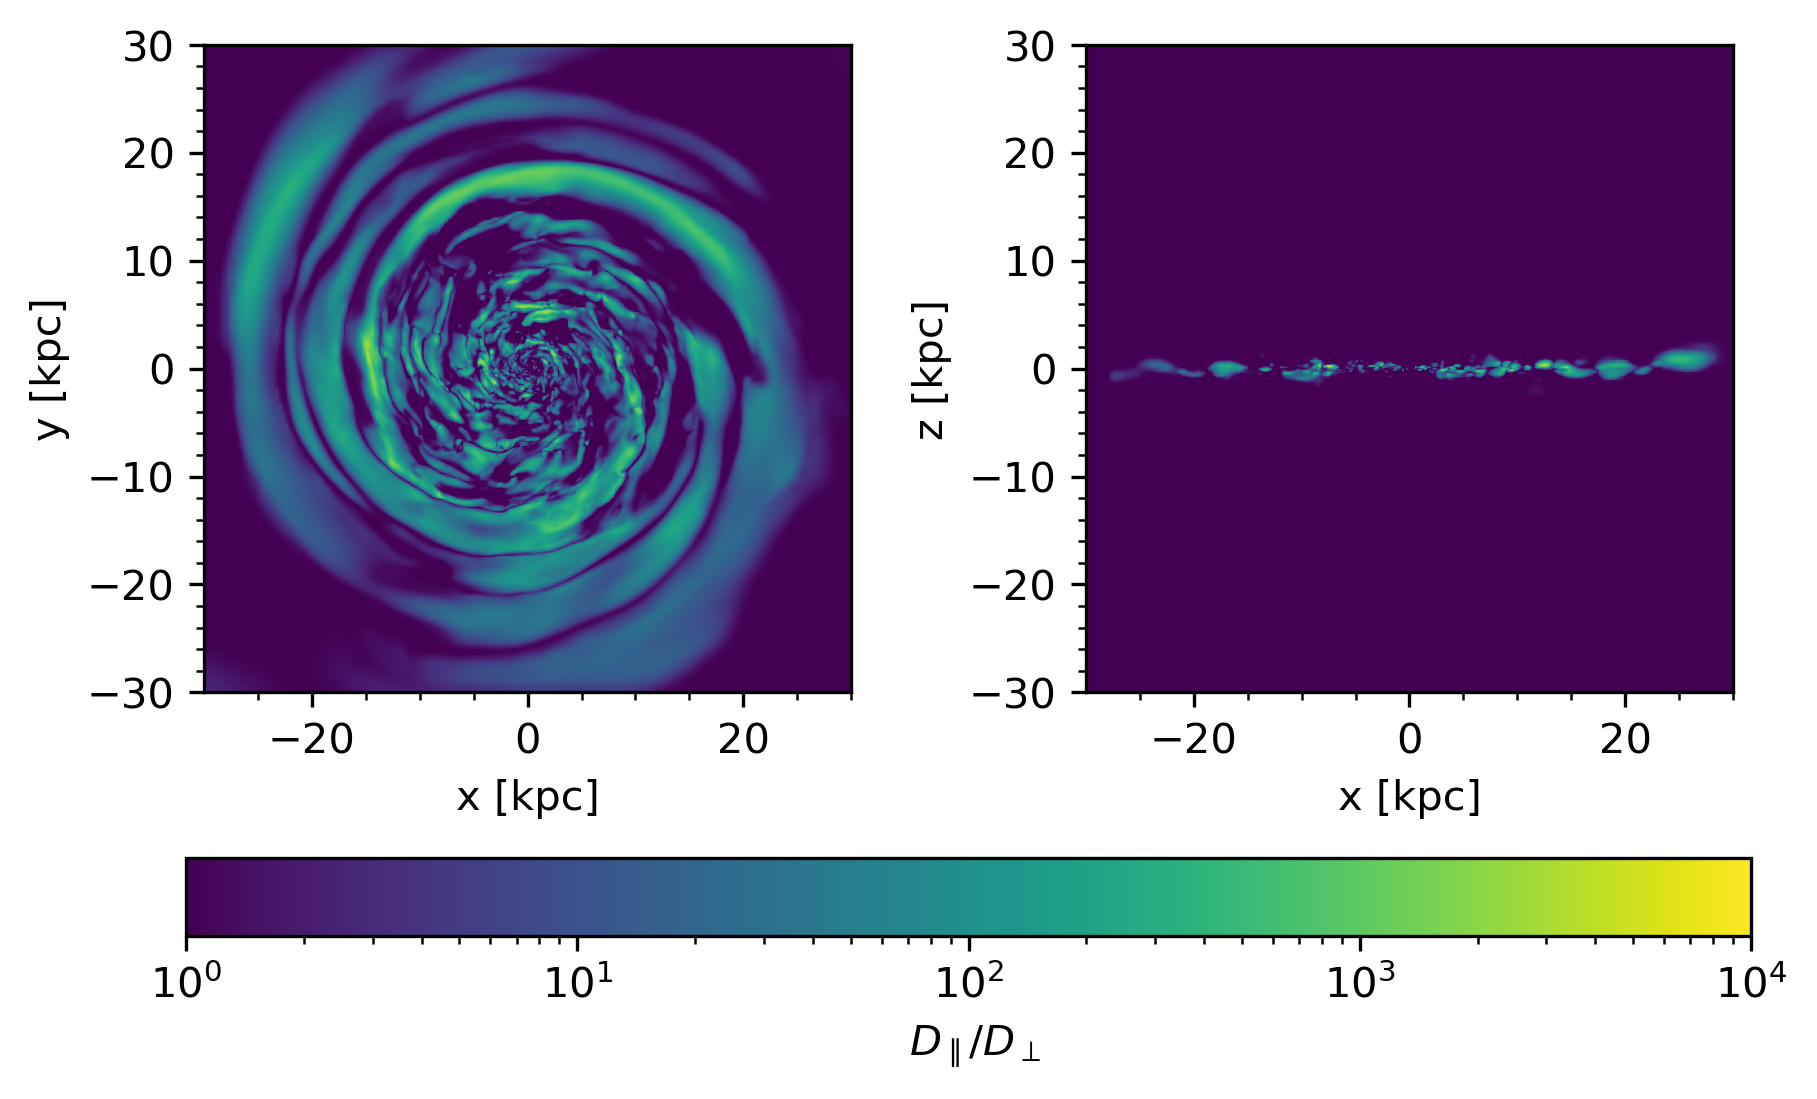

In [108]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w = 60
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='Dratio', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1, vmax=1e4, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='Dratio', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1, vmax=1e4, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $D_\parallel/D_\perp$")
plt.show()

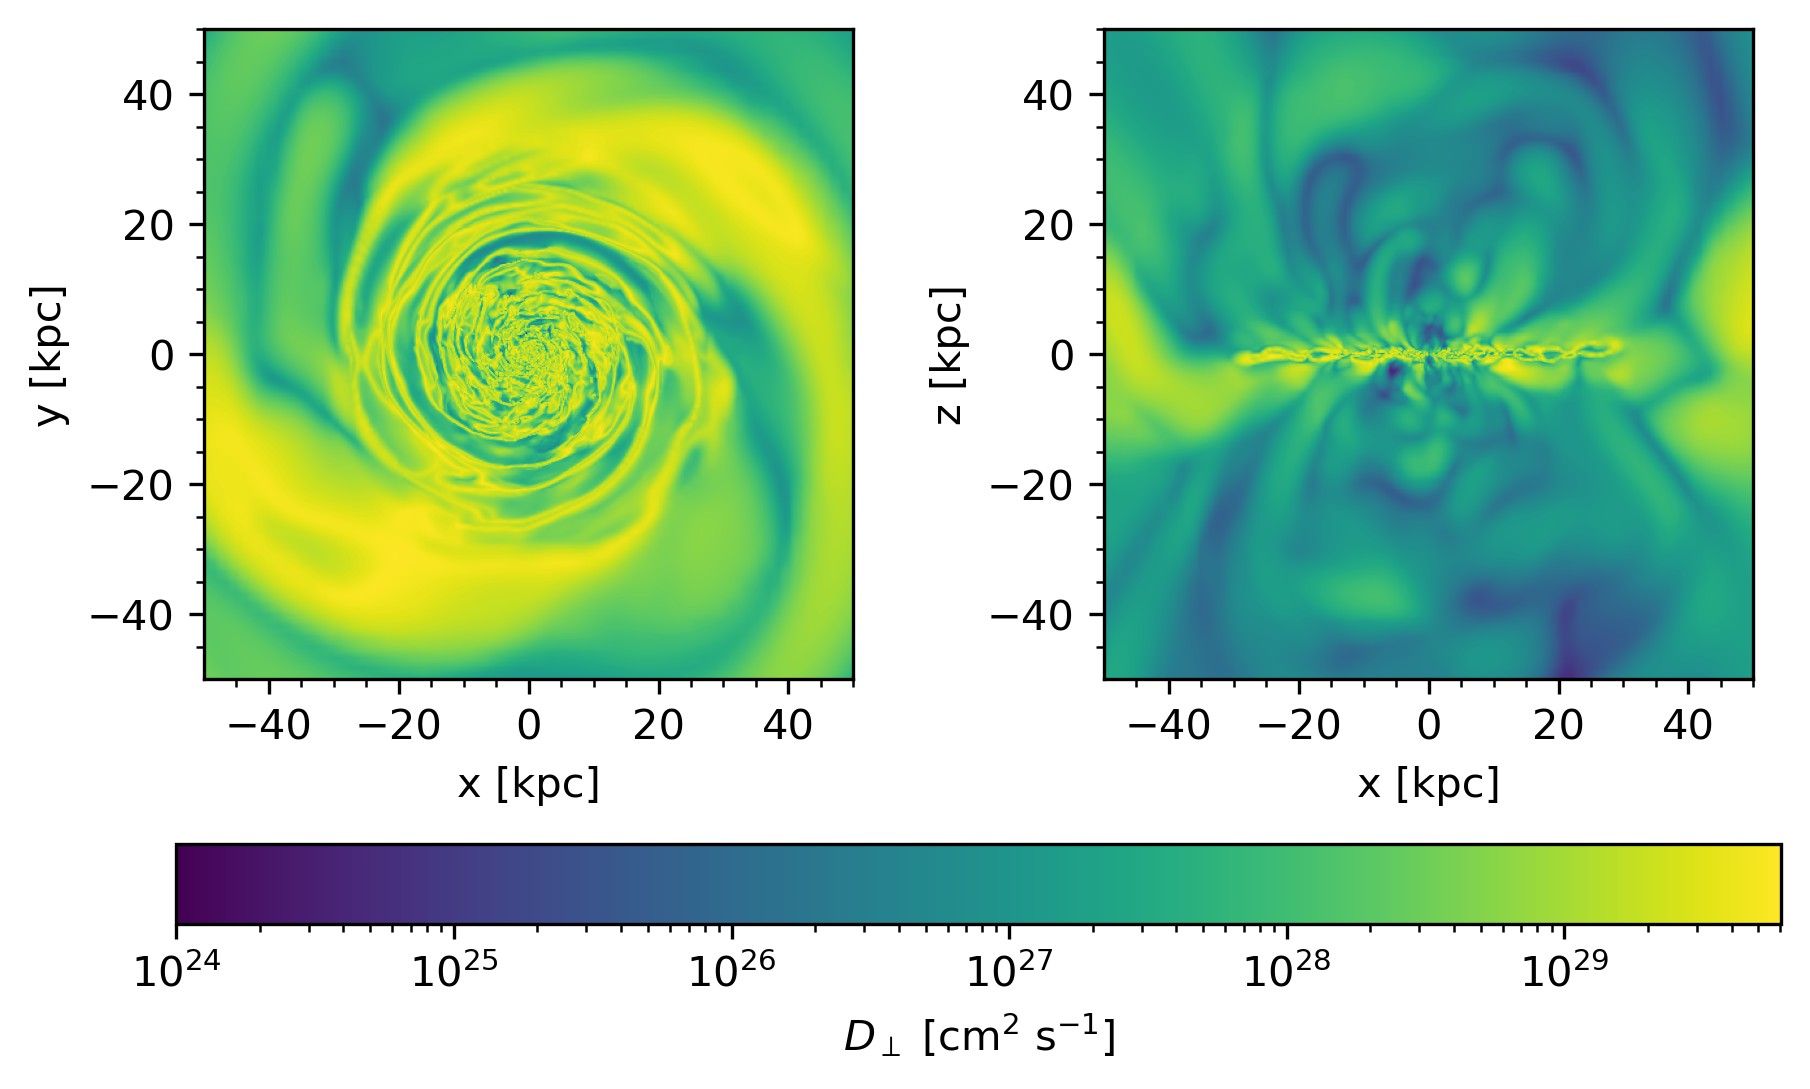

In [130]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)
w=100
with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='Dperp', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e24, vmax=Dperp.max(), resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='Dperp', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=1e24, vmax=Dperp.max(), resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r"$D_\perp$ [cm$^2$ s$^{-1}$]")
plt.show()

In [159]:
alphapar = 2 # 1.5
alphaperp = 2 # 1.8
l0 = data.gas['smooth'].in_units('cm').min() / 2

kratios = fit_kratios * l0**(alphapar-1)/l0**(alphaperp-1)
kpars = fit_kratios * fit_kperps * l0 **(alphapar-1) * data.gas['sigma1d'].in_units('cm s**-1')
kperps = fit_kperps * l0 **(alphaperp-1) * data.gas['sigma1d'].in_units('cm s**-1')
data.gas['kratio'] = pynbody.array.SimArray(kratios, units='')
data.gas['kpar'] = pynbody.array.SimArray(kpars, units='cm**2 s**-1')
data.gas['kperp'] = pynbody.array.SimArray(kperps, units='cm**2 s**-1')

kcrit = (data.gas['smooth'].in_units('cm').min()/2) * pynbody.array.SimArray(1e6, units='cm s**-1') / 3

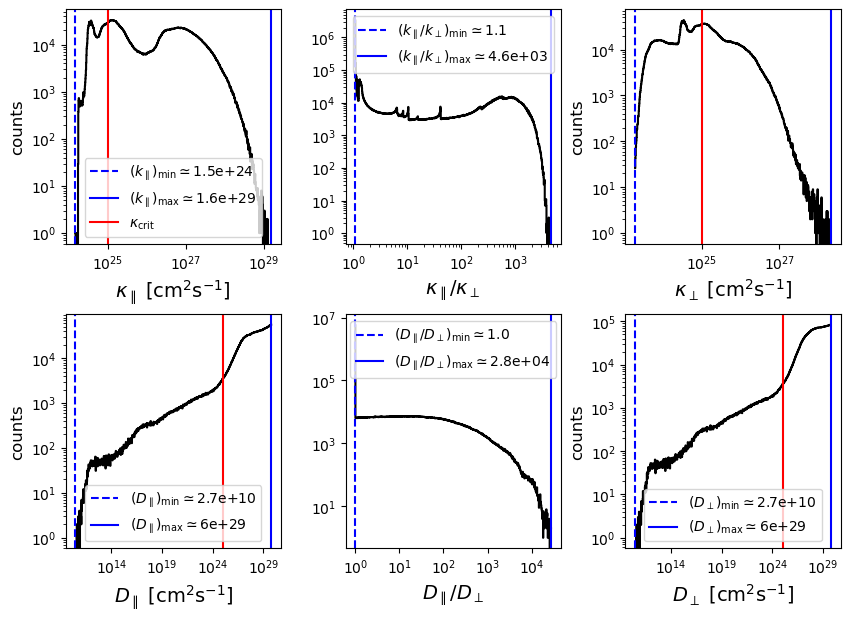

In [167]:
fig, ax = plt.subplots(2,3, figsize=(10,7))

h, bins = np.histogram(kpars, np.logspace(np.log10(kpars.min()),np.log10(kpars.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[0,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('$\kappa_\parallel$ [cm$^2$s$^{-1}$]', fontsize=14)
ax[0,0].set_ylabel('counts', fontsize=12)
ax[0,0].axvline(kpars.min(), label=r'$(k_\parallel)_{\rm{min}}\simeq$' +  '{:.2}'.format(kpars.min()),
                ls='--', color='b')
ax[0,0].axvline(kpars.max(), label=r'$(k_\parallel)_{\rm{max}}\simeq$' + '{:.2}'.format(kpars.max()), 
                ls='-', color='b')
ax[0,0].axvline(kcrit, color='r', label=r'$\kappa_{\rm{crit}}$')
ax[0,0].legend(loc='lower center')

h, bins = np.histogram(kratios, np.logspace(np.log10(kratios.min()),np.log10(kratios.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[0,1].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('$\kappa_\parallel/\kappa_\perp$', fontsize=14)
ax[0,1].axvline(kratios.min(), label=r'$(k_\parallel/k_\perp)_{\rm{min}}\simeq$' +  '{:.2}'.format(kratios.min()), 
                ls='--', color='b')
ax[0,1].axvline(kratios.max(), label=r'$(k_\parallel/k_\perp)_{\rm{max}}\simeq$' +  '{:.2}'.format(kratios.max()), 
                ls='-', color='b')
ax[0,1].legend()


h, bins = np.histogram(Dpar, np.logspace(np.log10(Dpar.min()),np.log10(Dpar.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[1,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('$D_\parallel$ [cm$^2$s$^{-1}$]', fontsize=14)
ax[1,0].set_ylabel('counts', fontsize=12)
ax[1,0].axvline(Dpar.min(), label=r'$(D_\parallel)_{\rm{min}}\simeq$' +  '{:.2}'.format(Dpar.min()),
                ls='--', color='b')
ax[1,0].axvline(Dpar.max(), label=r'$(D_\parallel)_{\rm{max}}\simeq$' +  '{:.2}'.format(Dpar.max()), 
                ls='-', color='b')
ax[1,0].legend(loc='lower center')
ax[1,0].axvline(kcrit, color='r')

h, bins = np.histogram(Dratio, np.logspace(np.log10(Dratio.min()),np.log10(Dratio.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[1,1].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('$D_\parallel/D_\perp$', fontsize=14)
ax[1,1].axvline(Dratio.min(), label=r'$(D_\parallel/D_\perp)_{\rm{min}}\simeq$' +  '{:.2}'.format(Dratio.min()),
                ls='--', color='b')
ax[1,1].axvline(Dratio.max(), label=r'$(D_\parallel/D_\perp)_{\rm{max}}\simeq$' +  '{:.2}'.format(Dratio.max()), 
                ls='-', color='b')
ax[1,1].legend(loc='upper center')
ax[1,1].set_xticks([1, 10, 100, 1e3, 1e4])

h, bins = np.histogram(kperps, np.logspace(np.log10(kperps.min()),np.log10(kperps.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[0,2].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,2].set_xscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('$\kappa_\perp$ [cm$^2$s$^{-1}$]', fontsize=14)
ax[0,2].set_ylabel('counts', fontsize=12)
ax[0,2].axvline(kperps.min(), label=r'$(k_\perp)_{\rm{min}}\simeq$' +  '{:.2}'.format(kperps.min()),
                  ls='--', color='b')
ax[0,2].axvline(kperps.max(), label=r'$(k_\perp)_{\rm{max}}\simeq$' + '{:.2}'.format(kperps.max()), 
                ls='-', color='b')
ax[0,2].axvline(kcrit, color='r', label=r'$\kappa_{\rm{crit}}$')


h, bins = np.histogram(Dperp, np.logspace(np.log10(Dperp.min()),np.log10(Dperp.max()), 800));
bins = (bins[1:] + bins[:-1]) / 2
ax[1,2].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].set_xlabel('$D_\perp$ [cm$^2$s$^{-1}$]', fontsize=14)
ax[1,2].set_ylabel('counts', fontsize=12)
ax[1,2].axvline(Dperp.min(), label=r'$(D_\perp)_{\rm{min}}\simeq$' +  '{:.2}'.format(Dperp.min()),
                ls='--', color='b')
ax[1,2].axvline(Dperp.max(), label=r'$(D_\perp)_{\rm{max}}\simeq$' +  '{:.2}'.format(Dperp.max()), 
                ls='-', color='b')
ax[1,2].legend(loc='lower center')
ax[1,2].axvline(kcrit, color='r')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

## Parallel Diffusion Coefficient:

In [168]:
datalow = data.gas[data.gas['M_A0'] < 1]
datahigh = data.gas[data.gas['M_A0'] > 1]

In [198]:
datalow.gas['Dpar'].std()/datalow.gas['Dpar'].mean()

SimArray(8.88000807e-15, '1.00e+00')

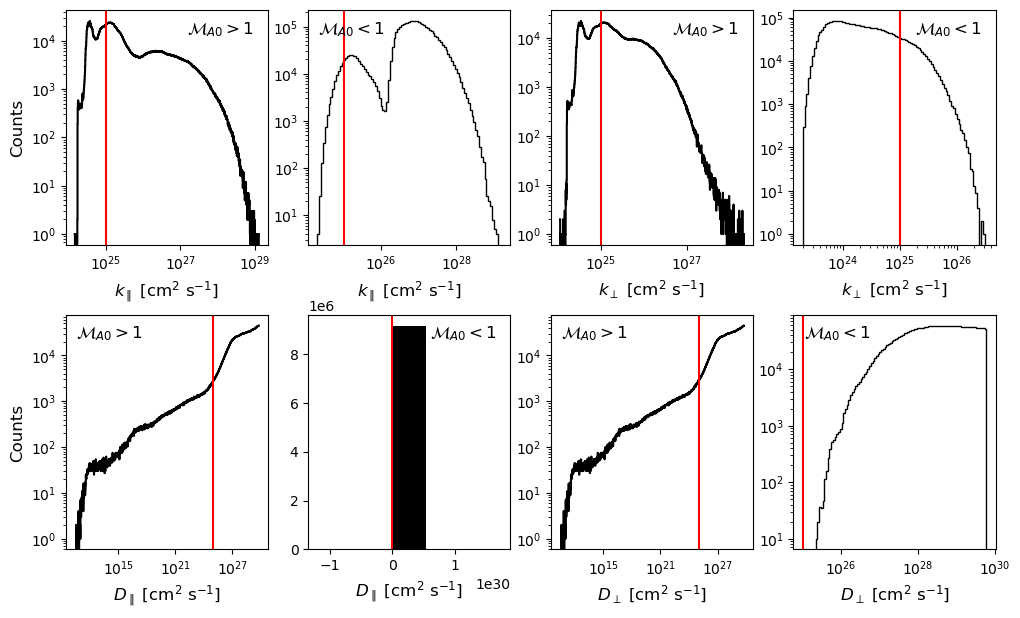

In [235]:
fig, ax = plt.subplots(2,4, figsize=(12,7))

# kpar, high
h, bins = np.histogram(datahigh.gas['kpar'], bins=np.logspace(np.log10(datahigh.gas['kpar'].min()), 
                                                  np.log10(datahigh.gas['kpar'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[0,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('$k_\parallel$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[0,0].set_ylabel('Counts', fontsize=12)
ax[0,0].text(0.6, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[0,0].transAxes)
ax[0,0].axvline(kcrit, color='r')

# kpar, low
ax[0,1].hist(datalow.gas['kpar'], bins=np.logspace(np.log10(datalow.gas['kpar'].min()), 
                                                  np.log10(datalow.gas['kpar'].max()), 100),
          color='k', histtype='step')
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('$k_\parallel$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[0,1].text(0.05, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[0,1].transAxes)
ax[0,1].axvline(kcrit, color='r')

#===================================================================================================

# Dpar, high
h, bins = np.histogram(datahigh.gas['Dpar'], bins=np.logspace(np.log10(datahigh.gas['Dpar'].min()), 
                                                  np.log10(datahigh.gas['Dpar'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[1,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('$D_\parallel$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[1,0].set_ylabel('Counts', fontsize=12)
ax[1,0].text(0.05, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[1,0].transAxes)
ax[1,0].axvline(kcrit, color='r')

# Dpar, low
ax[1,1].bar(x=data.gas['Dpar'].mean(), height=len(data.gas['Dpar']),
            width=2 * data.gas['Dpar'].std(), color='k');
ax[1,1].set_xlim(data.gas['Dpar'].mean() - 6*data.gas['Dpar'].std(), 
                 data.gas['Dpar'].mean() + 6*data.gas['Dpar'].std())
ax[1,1].set_xlabel('$D_\parallel$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[1,1].text(0.6, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[1,1].transAxes)
ax[1,1].axvline(kcrit, color='r')

#===================================================================================================

# kperp, high
h, bins = np.histogram(datahigh.gas['kperp'], bins=np.logspace(np.log10(datahigh.gas['kperp'].min()), 
                                                  np.log10(datahigh.gas['kperp'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[0,2].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,2].set_yscale('log')
ax[0,2].set_xscale('log')
ax[0,2].set_xlabel('$k_\perp$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[0,2].text(0.6, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[0,2].transAxes)
ax[0,2].axvline(kcrit, color='r')

# kperp, low
ax[0,3].hist(datalow.gas['kperp'], bins=np.logspace(np.log10(datalow.gas['kperp'].min()), 
                                                  np.log10(datalow.gas['kperp'].max()), 100),
          color='k', histtype='step')
ax[0,3].set_yscale('log')
ax[0,3].set_xscale('log')
ax[0,3].set_xlabel('$k_\perp$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[0,3].text(0.6, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[0,3].transAxes)
ax[0,3].axvline(kcrit, color='r')

#===================================================================================================

# Dperp, high
h, bins = np.histogram(datahigh.gas['Dperp'], bins=np.logspace(np.log10(datahigh.gas['Dperp'].min()), 
                                                  np.log10(datahigh.gas['Dperp'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[1,2].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,2].set_yscale('log')
ax[1,2].set_xscale('log')
ax[1,2].set_xlabel('$D_\perp$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[1,2].text(0.05, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[1,2].transAxes)
ax[1,2].axvline(kcrit, color='r')

# Dperp, low
ax[1,3].hist(datalow.gas['Dperp'], bins=np.logspace(np.log10(datalow.gas['Dperp'].min()), 
                                                  np.log10(datalow.gas['Dperp'].max()), 100),
          color='k', histtype='step')
ax[1,3].set_yscale('log')
ax[1,3].set_xscale('log')
ax[1,3].set_xlabel('$D_\perp$ [cm$^2$ s$^{-1}$]', fontsize=12)
ax[1,3].text(0.05, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[1,3].transAxes)
ax[1,3].axvline(kcrit, color='r')

plt.subplots_adjust(hspace=0.3, wspace=0.2)

Text(0.5, 0, '$\\mathcal{M}_{A0}^{-2}$')

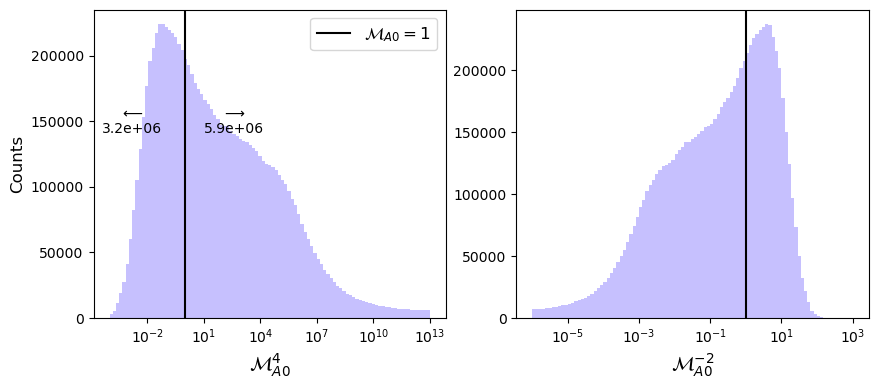

In [340]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.gas['M_A0']**4, bins=np.logspace(-4,13,100), alpha=0.5, color='xkcd:periwinkle');
ax[0].axvline(1, color='k', label='$\mathcal{M}_{A0}=1$')
ax[0].set_xscale('log')
ax[0].text(0.11, 0.6, '$\longleftarrow$\n{:.2}'.format(float(len(datalow))), 
         horizontalalignment='center', transform=ax[0].transAxes, fontsize=10)
ax[0].text(0.4, 0.6, '$\longrightarrow$\n{:.2}'.format(float(len(datahigh))), 
         horizontalalignment='center', transform=ax[0].transAxes, fontsize=10)
ax[0].set_xlabel('$\mathcal{M}_{A0}^4$', fontsize=14)
ax[0].set_ylabel('Counts', fontsize=12)
ax[0].legend(fontsize=12)

ax[1].hist(data.gas['M_A0']**-2, bins=np.logspace(-6,3,100), alpha=0.5, color='xkcd:periwinkle');
ax[1].axvline(1, color='k')
ax[1].set_xscale('log')
ax[1].set_xlabel('$\mathcal{M}_{A0}^{-2}$', fontsize=14)

Text(0, 0.5, 'log$_{10}(D_\\perp)$')

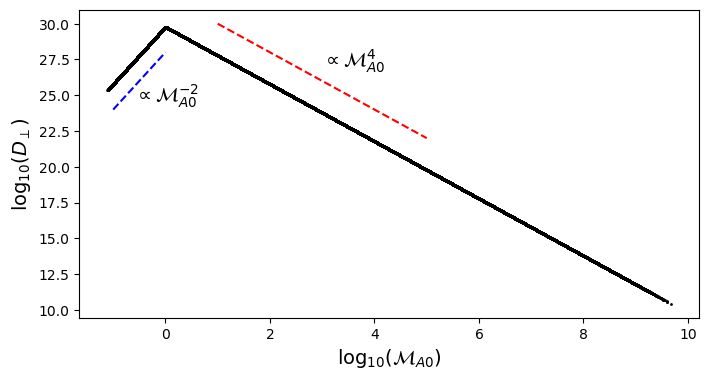

In [382]:
plt.figure(figsize=(8,4))
plt.scatter(np.log10(data.gas['M_A0']), np.log10(data.gas['Dperp']), s=1, color='k')
plt.plot(np.linspace(-1, 0, 10), 4 * np.linspace(-1, 0, 10)+28, color='b', ls='--')
plt.text(3, 27, '$\propto \mathcal{M}_{A0}^{4}$', fontsize=14)
plt.plot(np.linspace(1, 5, 100), -2 * np.linspace(1, 5, 100)+32, color='r', ls='--')
plt.text(-0.6, 24.5, '$\propto \mathcal{M}_{A0}^{-2}$', fontsize=14)
plt.xlabel('log$_{10}(\mathcal{M}_{A0})$', fontsize=14)
plt.ylabel('log$_{10}(D_\perp)$', fontsize=14)

Text(0, 0.5, 'log$_{10}(\\kappa_\\perp)$')

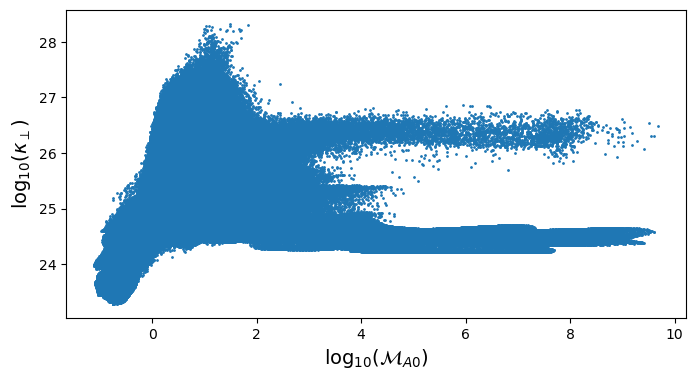

In [388]:
plt.figure(figsize=(8,4))
plt.scatter(np.log10(data.gas['M_A0']), np.log10(data.gas['kperp']), s=1)
plt.xlabel('log$_{10}(\mathcal{M}_{A0})$', fontsize=14)
plt.ylabel('log$_{10}(\kappa_\perp)$', fontsize=14)

### There is about equal amount of cells with subsonic as supersonic Alfven Mach number.

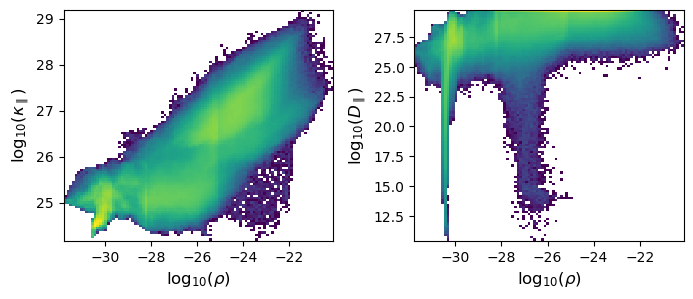

In [233]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), 
             np.log10(data.gas['kpar']), bins=100, norm=LogNorm());
ax[0].set_xlabel('log$_{10}(\\rho)$', fontsize=12)
ax[0].set_ylabel('log$_{10}(\kappa_\parallel)$', fontsize=12)

ax[1].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), 
             np.log10(data.gas['Dpar']), bins=100, norm=LogNorm());
ax[1].set_xlabel('log$_{10}(\\rho)$', fontsize=12)
ax[1].set_ylabel('log$_{10}(D_\parallel)$', fontsize=12)

plt.subplots_adjust(wspace=0.3)

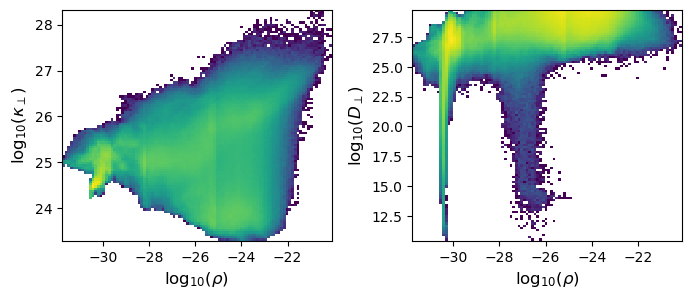

In [234]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), 
             np.log10(data.gas['kperp']), bins=100, norm=LogNorm());
ax[0].set_xlabel('log$_{10}(\\rho)$', fontsize=12)
ax[0].set_ylabel('log$_{10}(\kappa_\perp)$', fontsize=12)

ax[1].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), 
             np.log10(data.gas['Dperp']), bins=100, norm=LogNorm());
ax[1].set_xlabel('log$_{10}(\\rho)$', fontsize=12)
ax[1].set_ylabel('log$_{10}(D_\perp)$', fontsize=12)

plt.subplots_adjust(wspace=0.3)

Text(0, 0.5, 'Y')

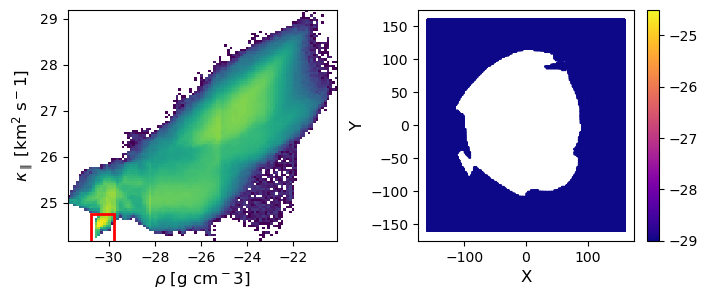

In [237]:
lowerx = -30.75
dx = 1
lowery = 24
dy = 0.75

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['kpar']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_xlabel('$\\rho$ [g cm$^-3$]', fontsize=12)
ax[0].set_ylabel('$\kappa_\parallel$ [km$^2$ s$^-1$]', fontsize=12)

plt.subplots_adjust(wspace=0.3)

logk = np.log10(data.gas['kpar'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logk>lowery)&(logk<lowery+dy)&(logrho>lowerx)&(logrho<lowerx+dx)
                                        
dataseg = data.gas[flag]

sc = ax[1].scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1, 
                   c=np.log10(dataseg.gas['rho'].in_units('g cm**-3')), cmap='plasma',
                  vmin=-29, vmax=-24.5)
plt.colorbar(mappable=sc, ax=ax[1])
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)

Text(0, 0.5, 'Y')

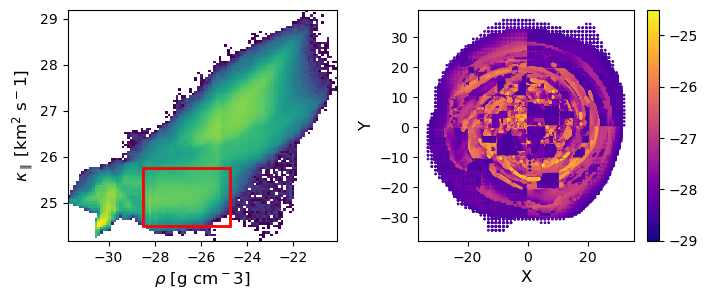

In [238]:
lowerx = -28.5
dx = 3.75
lowery = 24.5
dy = 1.25

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['kpar']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_xlabel('$\\rho$ [g cm$^-3$]', fontsize=12)
ax[0].set_ylabel('$\kappa_\parallel$ [km$^2$ s$^-1$]', fontsize=12)

plt.subplots_adjust(wspace=0.3)

logk = np.log10(data.gas['kpar'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logk>lowery)&(logk<lowery+dy)&(logrho>lowerx)&(logrho<lowerx+dx)
                                        
dataseg = data.gas[flag]

sc = ax[1].scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1, 
                   c=np.log10(dataseg.gas['rho'].in_units('g cm**-3')), cmap='plasma',
                  vmin=-29, vmax=-24.5)
plt.colorbar(mappable=sc, ax=ax[1])
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)

Text(0, 0.5, 'Y')

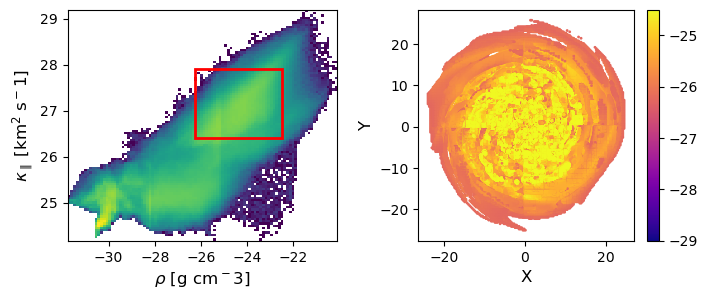

In [242]:
lowerx = -26.25
dx = 3.75
lowery = 26.4
dy = 1.5

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['kpar']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_xlabel('$\\rho$ [g cm$^-3$]', fontsize=12)
ax[0].set_ylabel('$\kappa_\parallel$ [km$^2$ s$^-1$]', fontsize=12)

plt.subplots_adjust(wspace=0.3)

logk = np.log10(data.gas['kpar'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logk>lowery)&(logk<lowery+dy)&(logrho>lowerx)&(logrho<lowerx+dx)
                                        
dataseg = data.gas[flag]

sc = ax[1].scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1, 
                   c=np.log10(dataseg.gas['rho'].in_units('g cm**-3')), cmap='plasma',
                  vmin=-29, vmax=-24.5)
plt.colorbar(mappable=sc, ax=ax[1])
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)

Text(0, 0.5, 'Y')

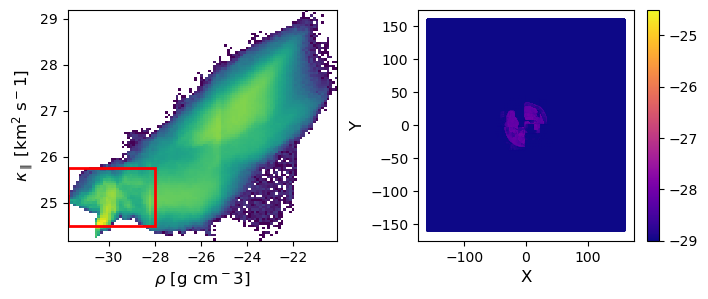

In [243]:
lowerx = -31.75
dx = 3.75
lowery = 24.5
dy = 1.25

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['kpar']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_xlabel('$\\rho$ [g cm$^-3$]', fontsize=12)
ax[0].set_ylabel('$\kappa_\parallel$ [km$^2$ s$^-1$]', fontsize=12)

plt.subplots_adjust(wspace=0.3)

logk = np.log10(data.gas['kpar'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logk>lowery)&(logk<lowery+dy)&(logrho>lowerx)&(logrho<lowerx+dx)
                                        
dataseg = data.gas[flag]

sc = ax[1].scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1, 
                   c=np.log10(dataseg.gas['rho'].in_units('g cm**-3')), cmap='plasma',
                  vmin=-29, vmax=-24.5)
plt.colorbar(mappable=sc, ax=ax[1])
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)

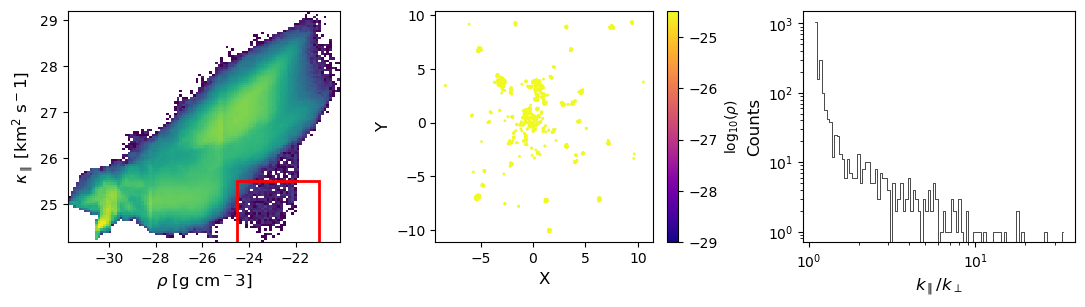

In [244]:
lowerx = -24.5
dx = 3.5
lowery = 24
dy = 1.5

fig, ax = plt.subplots(1,3, figsize=(13,3))
ax[0].hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['kpar']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_xlabel('$\\rho$ [g cm$^-3$]', fontsize=12)
ax[0].set_ylabel('$\kappa_\parallel$ [km$^2$ s$^-1$]', fontsize=12)

plt.subplots_adjust(wspace=0.3)

logk = np.log10(data.gas['kpar'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logk>lowery)&(logk<lowery+dy)&(logrho>lowerx)&(logrho<lowerx+dx)
                                        
dataseg = data.gas[flag]

sc = ax[1].scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1, 
                   c=np.log10(dataseg.gas['rho'].in_units('g cm**-3')), cmap='plasma',
                  vmin=-29, vmax=-24.5)
plt.colorbar(mappable=sc, ax=ax[1], label='log$_{10}(\\rho)$')
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)

h, bins = np.histogram(dataseg.gas['kratio'], bins=np.logspace(np.log10(dataseg.gas['kratio'].min()), 
                                                   np.log10(dataseg.gas['kratio'].max()), 100))
ax[2].plot((bins[:-1]+bins[1:])/2, h, drawstyle='steps-mid', color='k', lw=0.5);
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('$k_\parallel/k_\perp$', fontsize=12)
ax[2].set_ylabel('Counts', fontsize=12)

plt.subplots_adjust(wspace=0.35)

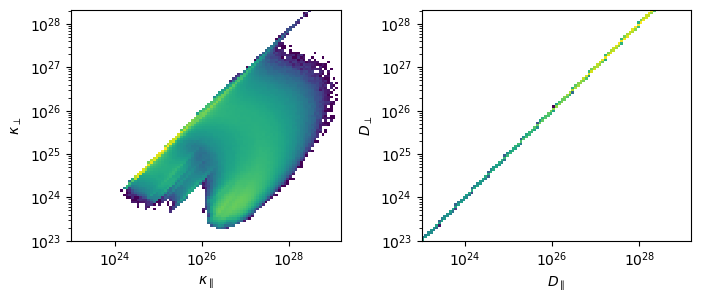

In [276]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
hx, binx = np.histogram(data.gas['kpar'], bins=np.logspace(23,
                                                           np.log10(data.gas['kpar']).max(), 100))
hy, biny = np.histogram(data.gas['kperp'], bins=np.logspace(23,
                                                           np.log10(data.gas['kperp']).max(), 100))
ax[0].hist2d(data.gas['kpar'], data.gas['kperp'], bins=[binx, biny], norm=LogNorm());
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$\kappa_\parallel$')
ax[0].set_ylabel('$\kappa_\perp$')

hx, binx = np.histogram(data.gas['Dpar'], bins=np.logspace(23,
                                                           np.log10(data.gas['kpar']).max(), 100))
hy, biny = np.histogram(data.gas['Dperp'], bins=np.logspace(23,
                                                           np.log10(data.gas['kperp']).max(), 100))
ax[1].hist2d(data.gas['Dpar'], data.gas['Dperp'], bins=[binx, biny], norm=LogNorm());
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$D_\parallel$')
ax[1].set_ylabel('$D_\perp$')

plt.subplots_adjust(wspace=0.3)

## Diffusion Coefficient Ratio - parallel/perp:

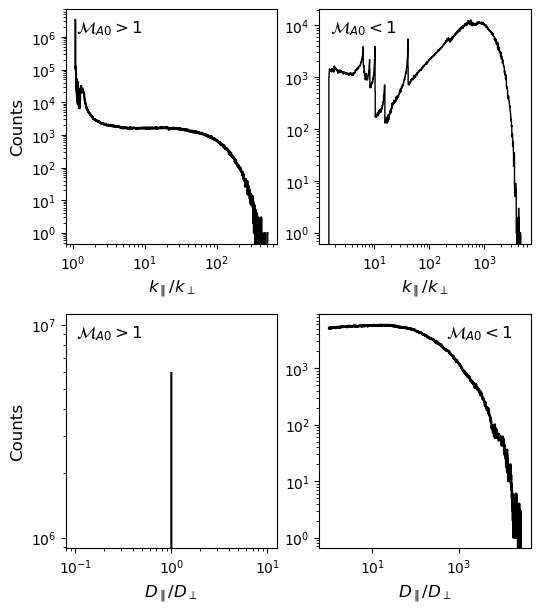

In [277]:
datalow = data.gas[data.gas['M_A0'] < 1]
datahigh = data.gas[data.gas['M_A0'] > 1]
fig, ax = plt.subplots(2,2, figsize=(6,7))

h, bins = np.histogram(datahigh.gas['kratio'], bins=np.logspace(np.log10(datahigh.gas['kratio'].min()), 
                                                  np.log10(datahigh.gas['kratio'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[0,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('$k_\parallel/k_\perp$', fontsize=12)
ax[0,0].set_ylabel('Counts', fontsize=12)
ax[0,0].text(0.05, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[0,0].transAxes)

ax[0,1].hist(datalow.gas['kratio'], bins=np.logspace(np.log10(datalow.gas['kratio'].min()), 
                                                  np.log10(datalow.gas['kratio'].max()), 1000),
          color='k', histtype='step')
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('$k_\parallel/k_\perp$', fontsize=12)
ax[0,1].text(0.05, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[0,1].transAxes)

h, bins = np.histogram(datahigh.gas['Dratio'], bins=np.logspace(np.log10(datahigh.gas['Dratio'].min()), 
                                                  np.log10(datahigh.gas['Dratio'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[1,0].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('$D_\parallel/D_\perp$', fontsize=12)
ax[1,0].set_ylabel('Counts', fontsize=12)
ax[1,0].text(0.05, 0.9, r'$\mathcal{M}_{A0} > 1$', fontsize=12, transform=ax[1,0].transAxes)


h, bins = np.histogram(datalow.gas['Dratio'], bins=np.logspace(np.log10(datalow.gas['Dratio'].min()), 
                                                  np.log10(datalow.gas['Dratio'].max()), 1000));
bins = (bins[:-1]+bins[1:]) / 2
ax[1,1].plot(bins, h, drawstyle='steps-mid', color='k')
ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('$D_\parallel/D_\perp$', fontsize=12)
ax[1,1].text(0.6, 0.9, r'$\mathcal{M}_{A0} < 1$', fontsize=12, transform=ax[1,1].transAxes)

plt.subplots_adjust(hspace=0.3, wspace=0.2)